# End-to-End KMeans Clustering Analysis for Typhoon Impact Data

This notebook implements a comprehensive clustering pipeline for post-tropical cyclone impact profiling with:
- Data preprocessing and feature selection
- Feature scaling with StandardScaler
- PCA dimensionality reduction
- Correlation analysis
- KMeans clustering with Optuna hyperparameter tuning
- MAACLI framework for interpretability
- Cluster visualization and profiling

**MAACLI Framework Components:**
- **M**odel-**A**gnostic: Works with any clustering algorithm
- **A**lgorithm-**A**gnostic: Independent of specific ML algorithms
- **C**luster **L**abel **I**nterpretation: Uses surrogate models for explanation

## 1. Import Required Libraries

In [222]:
# Core data manipulation and numerical libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn components
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.tree import DecisionTreeClassifier

# Hyperparameter optimization
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Check for XGBoost availability
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available, will use DecisionTree as surrogate model")

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")
print(f"✓ XGBoost available: {XGBOOST_AVAILABLE}")

✓ All libraries imported successfully!
✓ XGBoost available: True


## 2. Load and Explore Dataset

In [223]:
# Load the typhoon impact dataset
df = pd.read_csv('../data/typhoon_impact_with_extreme_weather.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Number of records: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (1776, 30)
Number of records: 1776
Number of features: 30

First 5 rows:


,Typhoon Name,Year,Region,Province,City/Municipality,Families,Person,Brgy,Dead,Injured/Ill,...,PAR_END,Duration_in_PAR_Hours,Max_Sustained_Wind_kph,Typhoon_Type,Max_24hr_Rainfall_mm,Total_Storm_Rainfall_mm,Min_Pressure_hPa,Weather_Station_Mapped,Weather_Records_Found,Weather_Days_Covered
0,BETTY,2023,2,BATANES,BASCO,3608,11120,6,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
1,BETTY,2023,2,BATANES,ITBAYAT,968,3028,5,0,0,...,6/1/2023,133.0,195,STY,20.3,32.71,1000.5,1,6,6
2,BETTY,2023,2,BATANES,IVANA,444,1532,4,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
3,BETTY,2023,2,BATANES,MAHATAO,575,1792,4,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
4,BETTY,2023,2,BATANES,SABTANG,575,1955,6,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6


In [224]:
# Display dataset info
print("=== Dataset Information ===")
df.info()

=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Typhoon Name             1776 non-null   object 
 1   Year                     1776 non-null   int64  
 2   Region                   1776 non-null   int64  
 3   Province                 1776 non-null   object 
 4   City/Municipality        1776 non-null   object 
 5   Families                 1776 non-null   int64  
 6   Person                   1776 non-null   int64  
 7   Brgy                     1776 non-null   int64  
 8   Dead                     1776 non-null   int64  
 9   Injured/Ill              1776 non-null   int64  
 10  Missing                  1776 non-null   int64  
 11  Totally                  1776 non-null   int64  
 12  Partially                1776 non-null   int64  
 13  Total                    1776 non-null   int64  
 

In [225]:
# Statistical summary
print("=== Statistical Summary ===")
df.describe()

=== Statistical Summary ===


,Year,Region,Families,Person,Brgy,Dead,Injured/Ill,Missing,Totally,Partially,...,Cost,Distance_km,Duration_in_PAR_Hours,Max_Sustained_Wind_kph,Max_24hr_Rainfall_mm,Total_Storm_Rainfall_mm,Min_Pressure_hPa,Weather_Station_Mapped,Weather_Records_Found,Weather_Days_Covered
count,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,...,1.776000e+03,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.0,1776.000000,1776.000000
mean,2021.216779,4.628941,1319.164414,5085.457770,8.808559,0.118243,0.329392,0.005631,56.121059,204.176802,...,3.067556e+05,37.478268,117.337669,139.304617,103.854302,168.839127,995.812331,1.0,5.604167,5.604167
std,0.943932,2.072282,3645.909584,13943.350619,11.442813,2.617296,2.711094,0.111187,399.704541,1029.153384,...,1.276232e+06,21.034558,37.039775,50.960721,71.202587,111.019046,10.057188,0.0,1.279685,1.279685
min,2020.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.131955,39.000000,45.000000,0.000000,0.000000,924.900000,1.0,2.000000,2.000000
25%,2020.000000,3.000000,16.000000,57.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,20.455268,91.000000,110.000000,50.400000,78.902500,992.200000,1.0,5.000000,5.000000
50%,2021.000000,5.000000,152.500000,589.500000,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,34.709542,122.000000,120.000000,98.500000,151.200000,998.100000,1.0,6.000000,6.000000
75%,2022.000000,5.000000,969.750000,3639.250000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,53.319704,124.700000,195.000000,136.200000,237.200000,1001.800000,1.0,6.000000,6.000000
max,2023.000000,8.000000,60550.000000,195016.000000,122.000000,95.000000,56.000000,4.000000,6588.000000,16719.000000,...,1.620751e+07,103.723427,198.000000,225.000000,510.000000,770.500000,1008.600000,1.0,8.000000,8.000000


## 3. Data Preprocessing

In [226]:
# Check for missing values
print("=== Missing Values ===")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])

if missing.sum() == 0:
    print("\n✓ No missing values found in the dataset!")

=== Missing Values ===
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

✓ No missing values found in the dataset!
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

✓ No missing values found in the dataset!


In [227]:
# Display column names and types
print("=== Column Names and Data Types ===")
for col in df.columns:
    print(f"  {col}: {df[col].dtype}")

=== Column Names and Data Types ===
  Typhoon Name: object
  Year: int64
  Region: int64
  Province: object
  City/Municipality: object
  Families: int64
  Person: int64
  Brgy: int64
  Dead: int64
  Injured/Ill: int64
  Missing: int64
  Totally: int64
  Partially: int64
  Total: int64
  Quantity: int64
  Cost: float64
  Nearest_Station: object
  Station_Province: object
  Distance_km: float64
  PAR_START: object
  PAR_END: object
  Duration_in_PAR_Hours: float64
  Max_Sustained_Wind_kph: int64
  Typhoon_Type: object
  Max_24hr_Rainfall_mm: float64
  Total_Storm_Rainfall_mm: float64
  Min_Pressure_hPa: float64
  Weather_Station_Mapped: int64
  Weather_Records_Found: int64
  Weather_Days_Covered: int64


In [228]:
# Create a copy for processing
df_processed = df.copy()

# Drop non-numeric and identifier columns for clustering
columns_to_drop = ['Typhoon Name', 'Province', 'City/Municipality', 
                   'Nearest_Station', 'Station_Province', 'PAR_START', 
                   'PAR_END', 'Typhoon_Type', 'Quantity']

# Only drop columns that exist
columns_to_drop = [col for col in columns_to_drop if col in df_processed.columns]
df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')

print(f"Columns dropped: {columns_to_drop}")
print(f"\nRemaining columns: {list(df_processed.columns)}")
print(f"Shape after dropping: {df_processed.shape}")

Columns dropped: ['Typhoon Name', 'Province', 'City/Municipality', 'Nearest_Station', 'Station_Province', 'PAR_START', 'PAR_END', 'Typhoon_Type', 'Quantity']

Remaining columns: ['Year', 'Region', 'Families', 'Person', 'Brgy', 'Dead', 'Injured/Ill', 'Missing', 'Totally', 'Partially', 'Total', 'Cost', 'Distance_km', 'Duration_in_PAR_Hours', 'Max_Sustained_Wind_kph', 'Max_24hr_Rainfall_mm', 'Total_Storm_Rainfall_mm', 'Min_Pressure_hPa', 'Weather_Station_Mapped', 'Weather_Records_Found', 'Weather_Days_Covered']
Shape after dropping: (1776, 21)


In [229]:
# Select numerical columns for clustering
numerical_columns = df_processed.select_dtypes(include=[np.number]).columns.tolist()

print(f"=== Numerical Features for Clustering ({len(numerical_columns)}) ===")
for i, col in enumerate(numerical_columns, 1):
    print(f"  {i}. {col}")

# Create feature matrix
X = df_processed[numerical_columns].values
print(f"\nFeature matrix shape: {X.shape}")

=== Numerical Features for Clustering (21) ===
  1. Year
  2. Region
  3. Families
  4. Person
  5. Brgy
  6. Dead
  7. Injured/Ill
  8. Missing
  9. Totally
  10. Partially
  11. Total
  12. Cost
  13. Distance_km
  14. Duration_in_PAR_Hours
  15. Max_Sustained_Wind_kph
  16. Max_24hr_Rainfall_mm
  17. Total_Storm_Rainfall_mm
  18. Min_Pressure_hPa
  19. Weather_Station_Mapped
  20. Weather_Records_Found
  21. Weather_Days_Covered

Feature matrix shape: (1776, 21)


In [230]:
# Standardize features
print("=== Feature Scaling ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Features standardized using StandardScaler")
print(f"  Mean (should be ~0): {X_scaled.mean(axis=0).mean():.6f}")
print(f"  Std (should be ~1): {X_scaled.std(axis=0).mean():.6f}")

=== Feature Scaling ===
✓ Features standardized using StandardScaler
  Mean (should be ~0): -0.000000
  Std (should be ~1): 0.952381
✓ Features standardized using StandardScaler
  Mean (should be ~0): -0.000000
  Std (should be ~1): 0.952381


## 4. Correlation Analysis

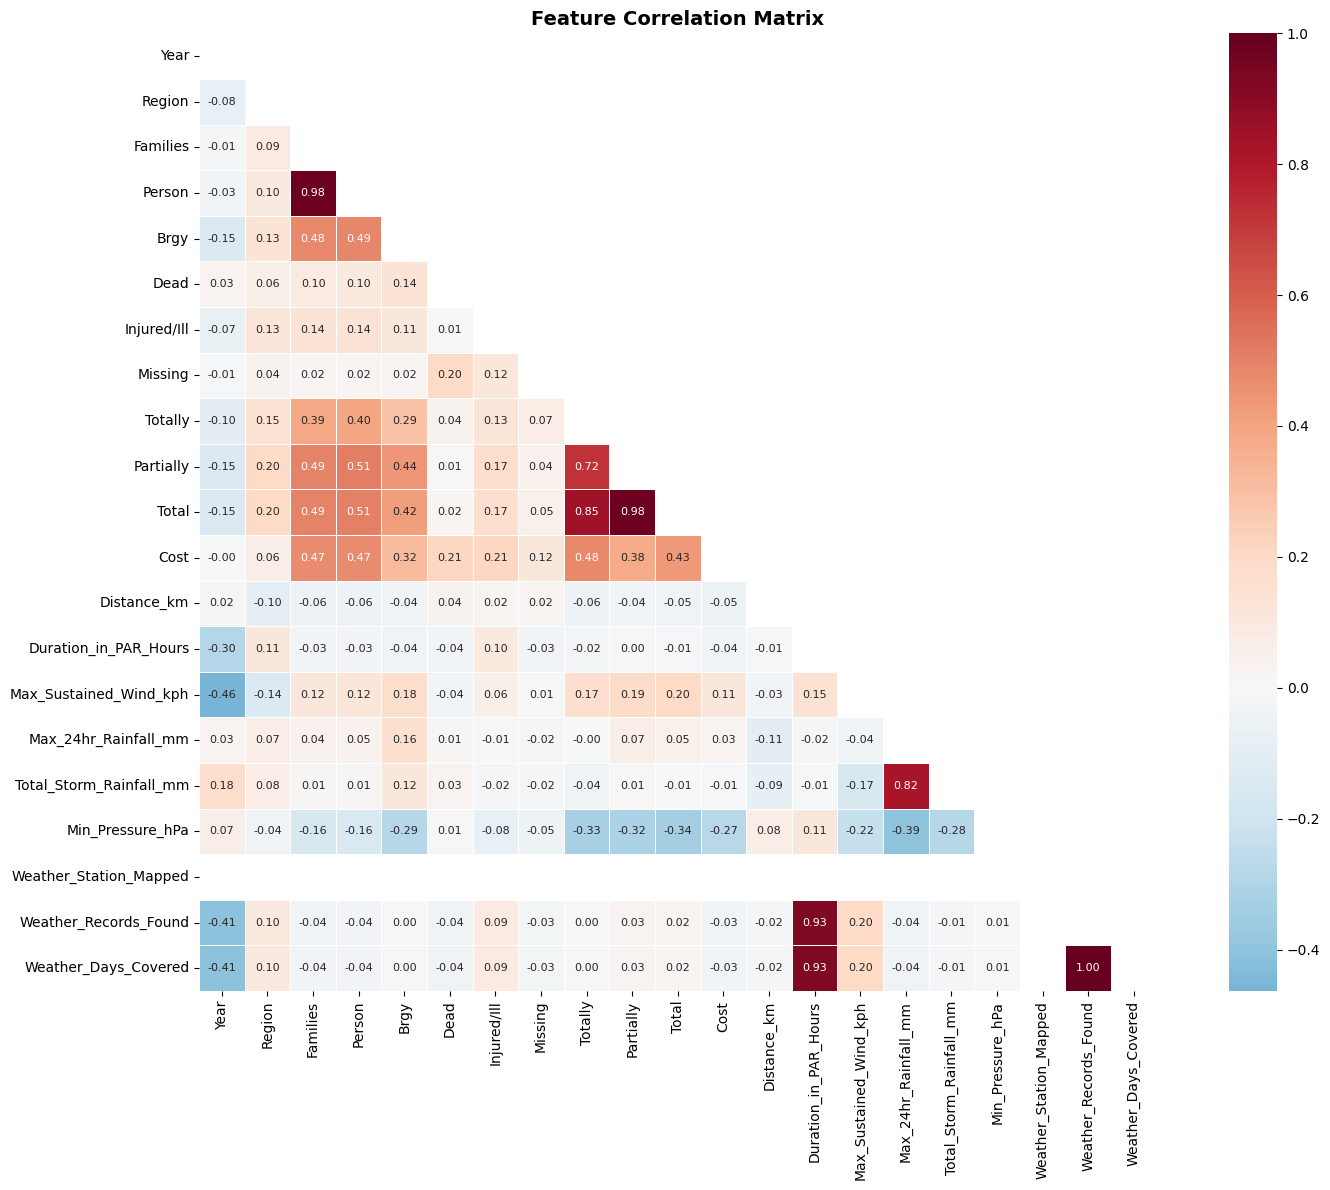


=== Highly Correlated Feature Pairs (|r| > 0.8) ===
  Families <-> Person: 0.981
  Totally <-> Total: 0.850
  Partially <-> Total: 0.979
  Duration_in_PAR_Hours <-> Weather_Records_Found: 0.932
  Duration_in_PAR_Hours <-> Weather_Days_Covered: 0.932
  Max_24hr_Rainfall_mm <-> Total_Storm_Rainfall_mm: 0.824
  Weather_Records_Found <-> Weather_Days_Covered: 1.000


In [231]:
# Compute correlation matrix
correlation_matrix = df_processed[numerical_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', 
            center=0, fmt='.2f', square=True, linewidths=0.5,
            annot_kws={'size': 8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated pairs
print("\n=== Highly Correlated Feature Pairs (|r| > 0.8) ===")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                corr_val
            ))
            print(f"  {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {corr_val:.3f}")

if not high_corr_pairs:
    print("  No highly correlated feature pairs found.")

## 5. Principal Component Analysis (PCA)

In [232]:
# Apply PCA for dimensionality reduction
n_components = min(10, X_scaled.shape[1])
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Print explained variance
print("=== PCA Results ===")
print(f"Number of components: {n_components}")
print(f"\nExplained Variance Ratios:")

cumulative_variance = 0
for i, ratio in enumerate(pca.explained_variance_ratio_):
    cumulative_variance += ratio
    print(f"  PC{i+1}: {ratio:.4f} (cumulative: {cumulative_variance:.4f})")

print(f"\n✓ Total explained variance: {cumulative_variance:.4f} ({cumulative_variance*100:.1f}%)")

=== PCA Results ===
Number of components: 10

Explained Variance Ratios:
  PC1: 0.2281 (cumulative: 0.2281)
  PC2: 0.1619 (cumulative: 0.3900)
  PC3: 0.1024 (cumulative: 0.4924)
  PC4: 0.0703 (cumulative: 0.5627)
  PC5: 0.0620 (cumulative: 0.6247)
  PC6: 0.0615 (cumulative: 0.6863)
  PC7: 0.0502 (cumulative: 0.7365)
  PC8: 0.0476 (cumulative: 0.7841)
  PC9: 0.0454 (cumulative: 0.8295)
  PC10: 0.0386 (cumulative: 0.8681)

✓ Total explained variance: 0.8681 (86.8%)


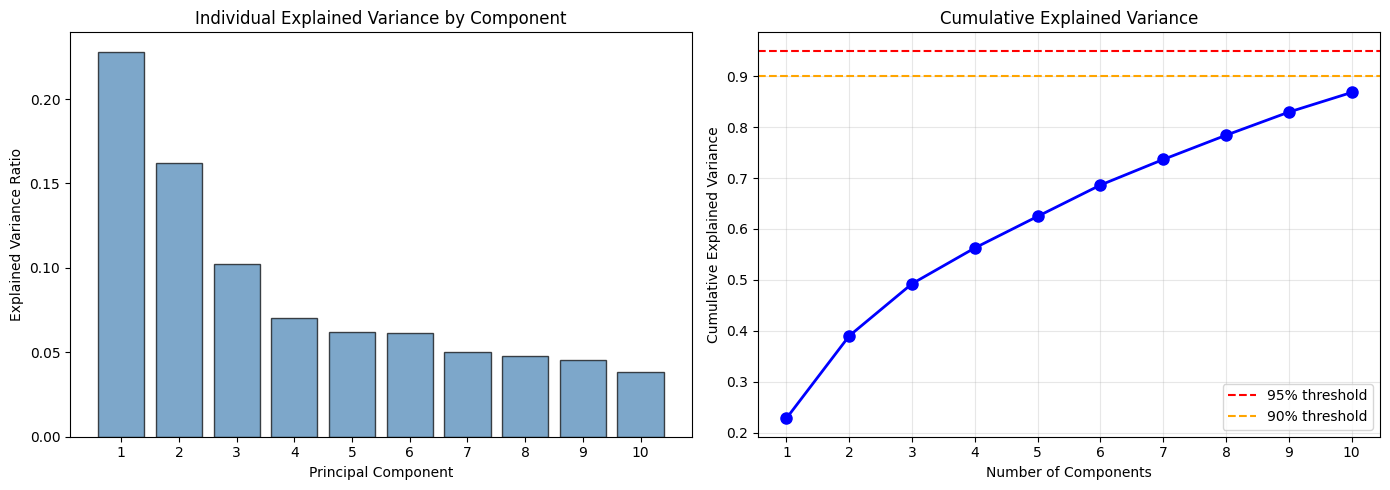

In [233]:
# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual explained variance
axes[0].bar(range(1, n_components + 1), pca.explained_variance_ratio_, 
            alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Individual Explained Variance by Component')
axes[0].set_xticks(range(1, n_components + 1))

# Cumulative explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, n_components + 1), cumsum, 'bo-', linewidth=2, markersize=8)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xticks(range(1, n_components + 1))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. KMeans Clustering with Optuna Hyperparameter Tuning

In [234]:
# First, let's find optimal k using Elbow Method and Silhouette Score
print("=== Finding Optimal Number of Clusters ===")

k_range = range(2, 13)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))
    calinski_scores.append(calinski_harabasz_score(X_pca, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_pca, kmeans.labels_))
    print(f"  k={k}: Silhouette={silhouette_scores[-1]:.4f}, Inertia={inertias[-1]:.2f}")

=== Finding Optimal Number of Clusters ===
  k=2: Silhouette=0.6401, Inertia=25762.32
  k=3: Silhouette=0.2096, Inertia=22398.84
  k=4: Silhouette=0.1879, Inertia=20692.21
  k=3: Silhouette=0.2096, Inertia=22398.84
  k=4: Silhouette=0.1879, Inertia=20692.21
  k=5: Silhouette=0.1960, Inertia=18556.98
  k=6: Silhouette=0.2186, Inertia=17161.61
  k=5: Silhouette=0.1960, Inertia=18556.98
  k=6: Silhouette=0.2186, Inertia=17161.61
  k=7: Silhouette=0.2218, Inertia=15531.34
  k=8: Silhouette=0.2306, Inertia=14410.73
  k=7: Silhouette=0.2218, Inertia=15531.34
  k=8: Silhouette=0.2306, Inertia=14410.73
  k=9: Silhouette=0.2326, Inertia=13110.08
  k=9: Silhouette=0.2326, Inertia=13110.08
  k=10: Silhouette=0.2334, Inertia=12381.64
  k=11: Silhouette=0.2385, Inertia=11123.77
  k=10: Silhouette=0.2334, Inertia=12381.64
  k=11: Silhouette=0.2385, Inertia=11123.77
  k=12: Silhouette=0.2409, Inertia=10351.02
  k=12: Silhouette=0.2409, Inertia=10351.02


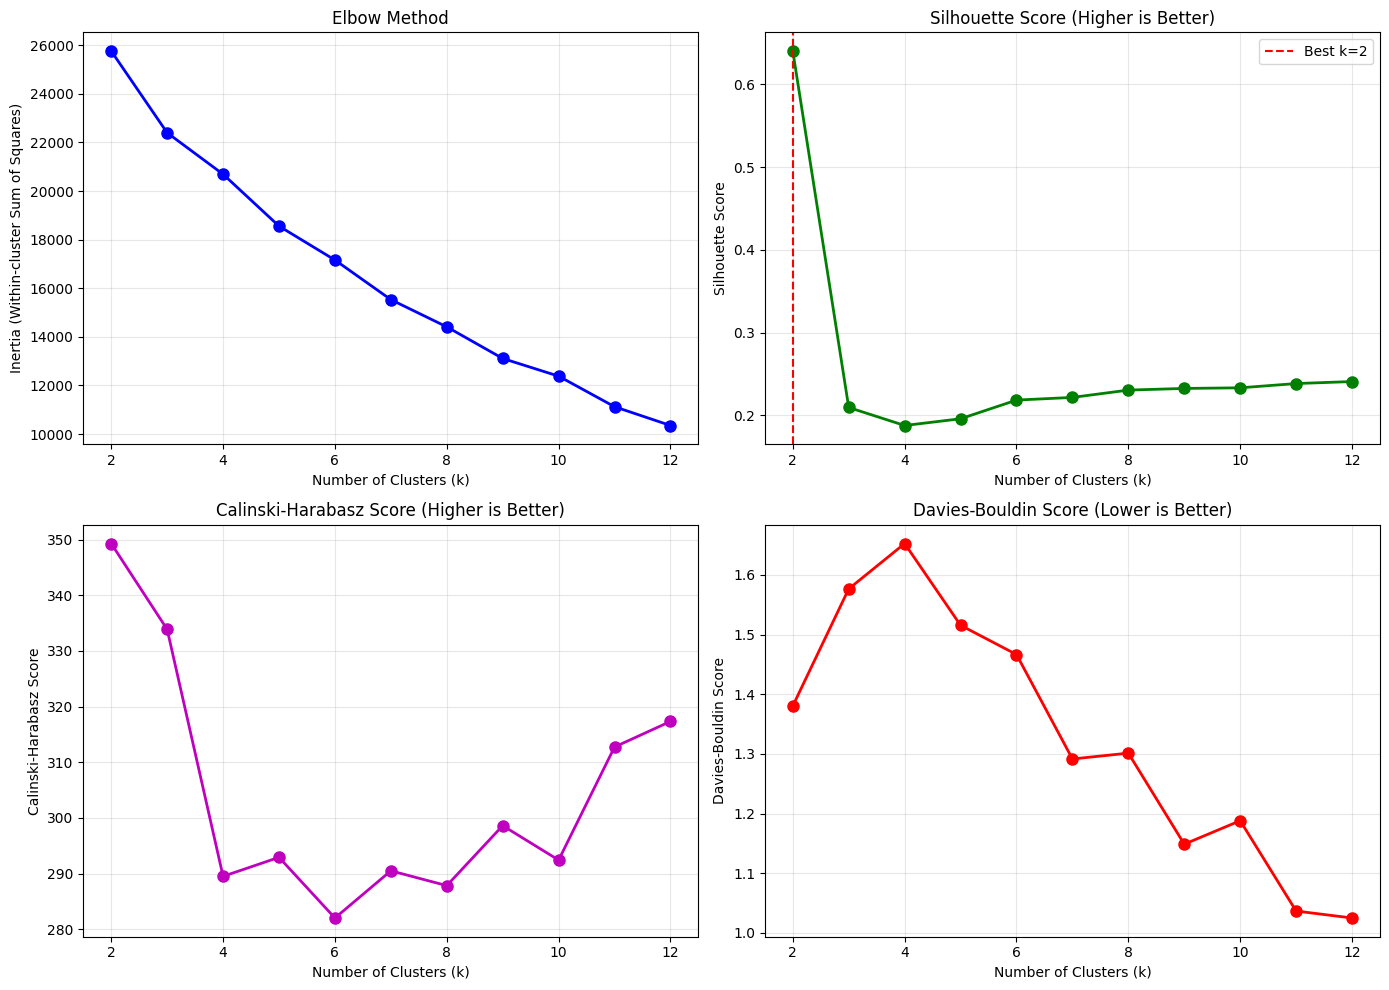


✓ Best k by Silhouette Score: 2


In [235]:
# Plot clustering evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow Method
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia (Within-cluster Sum of Squares)')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
best_k_silhouette = list(k_range)[np.argmax(silhouette_scores)]
axes[0, 1].axvline(x=best_k_silhouette, color='r', linestyle='--', 
                   label=f'Best k={best_k_silhouette}')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher is Better)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz Score
axes[1, 0].plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[1, 0].grid(True, alpha=0.3)

# Davies-Bouldin Score
axes[1, 1].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Score')
axes[1, 1].set_title('Davies-Bouldin Score (Lower is Better)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Best k by Silhouette Score: {best_k_silhouette}")

In [236]:
# Optimize KMeans using Optuna with FIXED k=3 clusters
def objective(trial):
    """Optuna objective function for KMeans optimization with fixed k=3."""
    # FIXED: Using 3 clusters as requested
    n_clusters = 3
    init_method = trial.suggest_categorical('init', ['k-means++', 'random'])
    n_init = trial.suggest_int('n_init', 10, 50)
    
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init_method,
        n_init=n_init,
        random_state=42,
        max_iter=300
    )
    
    cluster_labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, cluster_labels)
    
    return score

# Run optimization
print("=== Optuna Hyperparameter Optimization (k=3 clusters) ===")
print("Optimizing KMeans parameters with fixed k=3...\n")

study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Add n_clusters to best_params since it's fixed
best_params = study.best_params
best_params['n_clusters'] = 3  # Fixed at 3 clusters
best_score = study.best_value

print(f"\n=== Optimization Results ===")
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters:")
for param, value in best_params.items():
    print(f"  • {param}: {value}")

=== Optuna Hyperparameter Optimization (k=3 clusters) ===
Optimizing KMeans parameters with fixed k=3...



  0%|          | 0/50 [00:00<?, ?it/s]


=== Optimization Results ===
Best Silhouette Score: 0.2096
Best Parameters:
  • init: random
  • n_init: 40
  • n_clusters: 3


In [237]:
# Fit the best KMeans model
print("=== Training Final KMeans Model ===")

best_kmeans = KMeans(
    n_clusters=best_params['n_clusters'],
    init=best_params['init'],
    n_init=best_params['n_init'],
    random_state=42,
    max_iter=300
)

cluster_labels = best_kmeans.fit_predict(X_pca)

# Add cluster labels to the dataframe
df_clustered = df_processed.copy()
df_clustered['cluster_label'] = cluster_labels

# Also add to original dataframe for reference
df['cluster_label'] = cluster_labels

print(f"\n✓ Clustering Complete!")
print(f"  • Number of clusters: {best_params['n_clusters']}")
print(f"  • Silhouette Score: {best_score:.4f}")
print(f"  • Calinski-Harabasz Score: {calinski_harabasz_score(X_pca, cluster_labels):.2f}")
print(f"  • Davies-Bouldin Score: {davies_bouldin_score(X_pca, cluster_labels):.4f}")

print(f"\n=== Cluster Distribution ===")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(cluster_labels) * 100
    print(f"  Cluster {cluster}: {count:,} samples ({pct:.1f}%)")

=== Training Final KMeans Model ===

✓ Clustering Complete!
  • Number of clusters: 3
  • Silhouette Score: 0.2096
  • Calinski-Harabasz Score: 333.87
  • Davies-Bouldin Score: 1.5765

=== Cluster Distribution ===
  Cluster 0: 1,206 samples (67.9%)
  Cluster 1: 70 samples (3.9%)
  Cluster 2: 500 samples (28.2%)


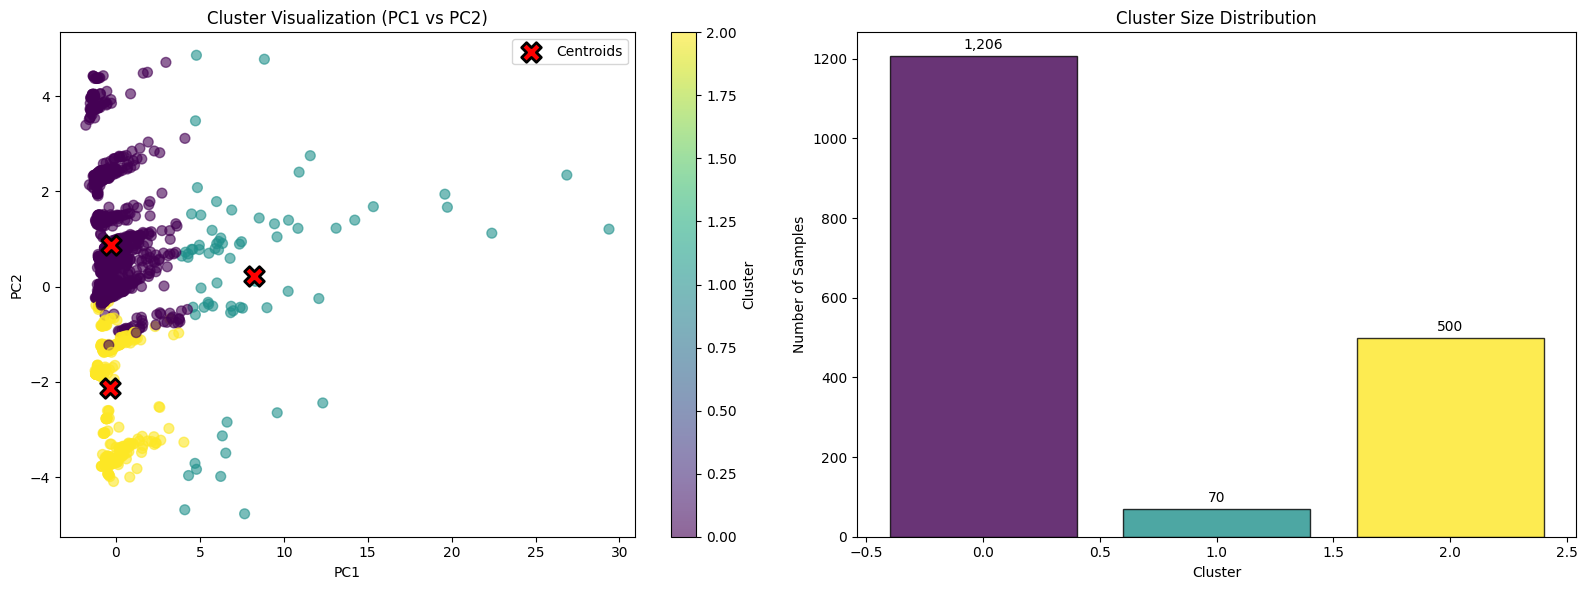

In [238]:
# Visualize clusters in PCA space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2D PCA plot
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                          cmap='viridis', alpha=0.6, s=50)
centers = best_kmeans.cluster_centers_
axes[0].scatter(centers[:, 0], centers[:, 1], c='red', marker='X', 
                s=200, edgecolors='black', linewidths=2, label='Centroids')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Cluster Visualization (PC1 vs PC2)')
axes[0].legend()
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Cluster distribution bar plot
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_counts)))
bars = axes[1].bar(cluster_counts.index, cluster_counts.values, color=colors, 
                   edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Cluster Size Distribution')

# Add value labels on bars
for bar, count in zip(bars, cluster_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                 f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

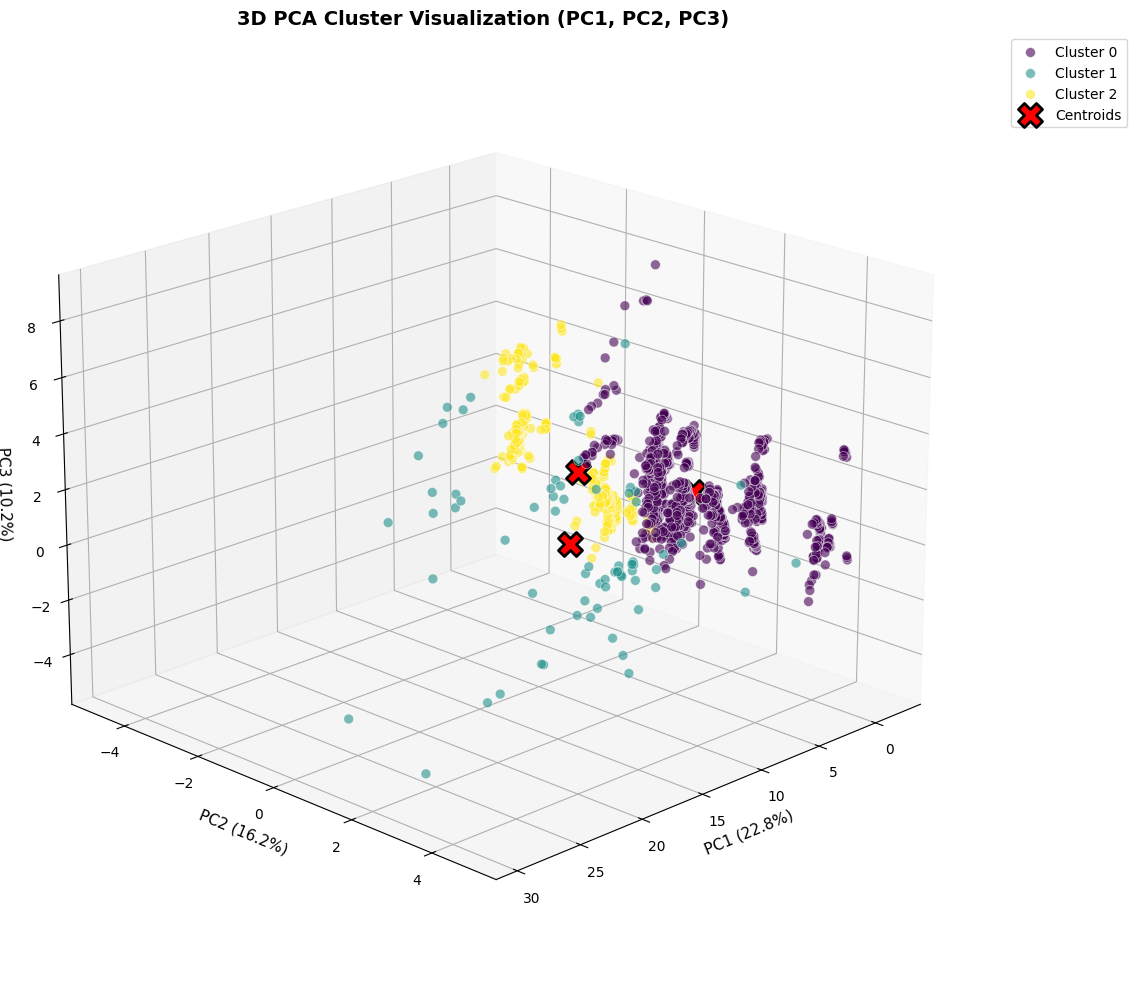


✓ Total variance explained by first 3 PCs: 49.24%
  • PC1: 22.81%
  • PC2: 16.19%
  • PC3: 10.24%


In [239]:
# 3D PCA Visualization of Clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique clusters and create color map
unique_clusters = np.unique(cluster_labels)
colors_3d = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Plot each cluster
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
               c=[colors_3d[i]], label=f'Cluster {cluster}',
               alpha=0.6, s=50, edgecolors='white', linewidths=0.5)

# Plot centroids in 3D
centers = best_kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
           c='red', marker='X', s=300, edgecolors='black',
           linewidths=2, label='Centroids', depthshade=False)

# Labels and title
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
ax.set_title('3D PCA Cluster Visualization (PC1, PC2, PC3)', fontsize=14, fontweight='bold')

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust viewing angle for better visualization
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# Print variance explained by first 3 components
total_var_3pc = sum(pca.explained_variance_ratio_[:3])
print(f"\n✓ Total variance explained by first 3 PCs: {total_var_3pc*100:.2f}%")
print(f"  • PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  • PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  • PC3: {pca.explained_variance_ratio_[2]*100:.2f}%")

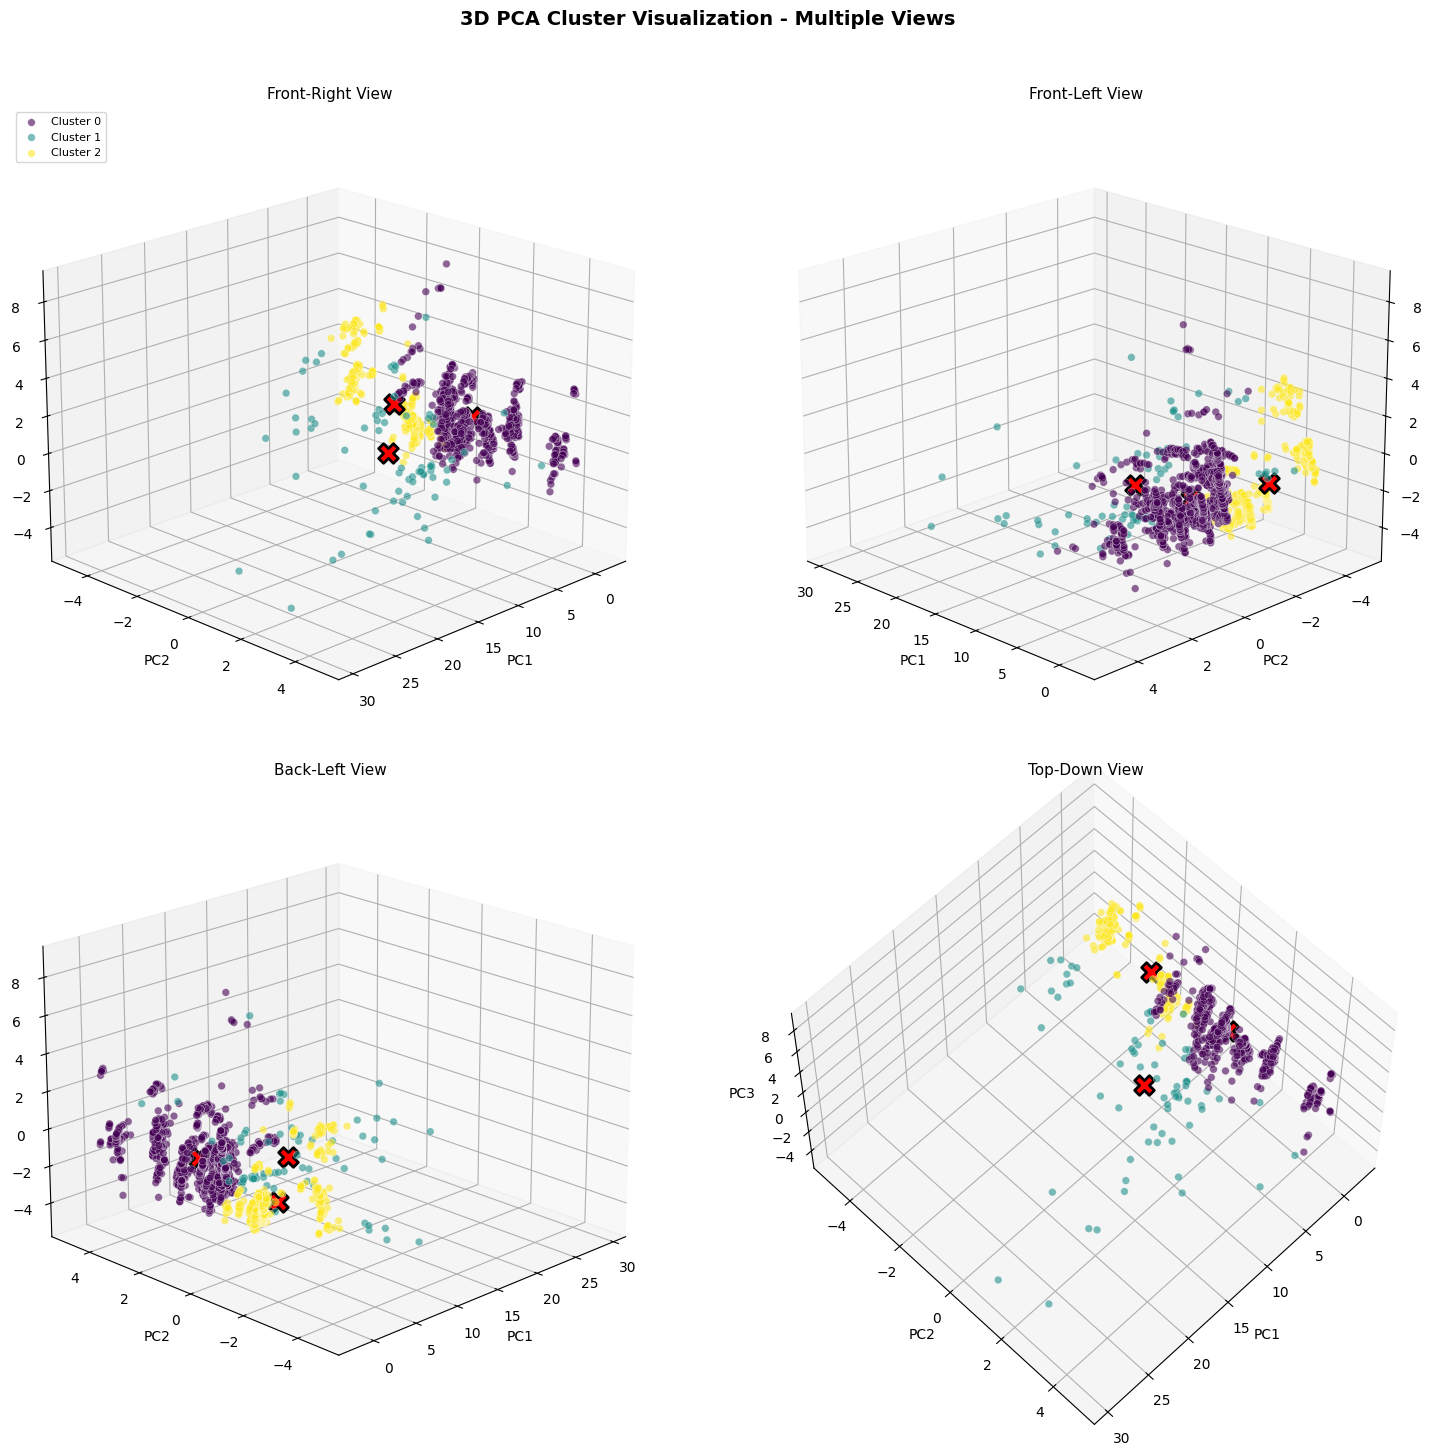

In [240]:
# Multiple viewing angles for 3D PCA
fig, axes = plt.subplots(2, 2, figsize=(16, 14), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# Different viewing angles
view_angles = [(20, 45), (20, 135), (20, 225), (60, 45)]
view_titles = ['Front-Right View', 'Front-Left View', 'Back-Left View', 'Top-Down View']

for ax, (elev, azim), title in zip(axes, view_angles, view_titles):
    # Plot each cluster
    for i, cluster in enumerate(unique_clusters):
        mask = cluster_labels == cluster
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
                   c=[colors_3d[i]], label=f'Cluster {cluster}' if ax == axes[0] else '',
                   alpha=0.6, s=30, edgecolors='white', linewidths=0.3)
    
    # Plot centroids
    ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
               c='red', marker='X', s=200, edgecolors='black',
               linewidths=2, depthshade=False)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(title, fontsize=11)
    ax.view_init(elev=elev, azim=azim)

# Add legend to first subplot only
axes[0].legend(loc='upper left', fontsize=8)

plt.suptitle('3D PCA Cluster Visualization - Multiple Views', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. MAACLI Framework Implementation

### Model-Agnostic Algorithm-Agnostic Cluster Label Interpretation

The MAACLI framework provides interpretability through:
- **Model-Agnostic**: Works with any clustering algorithm
- **Algorithm-Agnostic**: Uses surrogate models for interpretation
- **Local + Global Interpretability**: Feature importance analysis

In [241]:
# Train surrogate model for cluster interpretation
print("=== MAACLI Framework: Training Surrogate Model ===")

# Split data for surrogate model training
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, cluster_labels, test_size=0.3, random_state=42, stratify=cluster_labels
)

# Choose surrogate model
if XGBOOST_AVAILABLE:
    print("Using XGBoost as surrogate model...")
    surrogate_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    )
    model_type = "XGBoost"
else:
    print("Using Decision Tree as surrogate model...")
    surrogate_model = DecisionTreeClassifier(
        random_state=42,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10
    )
    model_type = "Decision Tree"

# Train the surrogate model
surrogate_model.fit(X_train, y_train)

# Evaluate surrogate model
y_pred = surrogate_model.predict(X_test)
accuracy = (y_pred == y_test).mean()

print(f"\n✓ {model_type} Surrogate Model Performance:")
print(f"  • Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")

# Get feature importance
feature_importance = surrogate_model.feature_importances_

=== MAACLI Framework: Training Surrogate Model ===
Using XGBoost as surrogate model...

✓ XGBoost Surrogate Model Performance:
  • Accuracy: 0.9812 (98.1%)

✓ XGBoost Surrogate Model Performance:
  • Accuracy: 0.9812 (98.1%)


In [242]:
# MAACLI Interpretation: Feature Importance Analysis
print("=== MAACLI Framework: Feature Importance Analysis ===")
print("Global interpretability for cluster assignments\n")

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': numerical_columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
for idx, row in importance_df.iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

# Identify top contributing features
top_features = importance_df.head(5)['Feature'].tolist()
print(f"\n✓ Top 5 most important features for cluster separation:")
for i, feat in enumerate(top_features, 1):
    print(f"  {i}. {feat}")

=== MAACLI Framework: Feature Importance Analysis ===
Global interpretability for cluster assignments

Feature Importance Ranking:
  Duration_in_PAR_Hours: 0.3008
  Max_Sustained_Wind_kph: 0.2830
  Total: 0.1377
  Total_Storm_Rainfall_mm: 0.0783
  Totally: 0.0450
  Max_24hr_Rainfall_mm: 0.0263
  Min_Pressure_hPa: 0.0258
  Cost: 0.0247
  Region: 0.0168
  Person: 0.0163
  Families: 0.0126
  Partially: 0.0108
  Injured/Ill: 0.0065
  Distance_km: 0.0049
  Year: 0.0048
  Weather_Records_Found: 0.0036
  Brgy: 0.0021
  Missing: 0.0000
  Dead: 0.0000
  Weather_Station_Mapped: 0.0000
  Weather_Days_Covered: 0.0000

✓ Top 5 most important features for cluster separation:
  1. Duration_in_PAR_Hours
  2. Max_Sustained_Wind_kph
  3. Total
  4. Total_Storm_Rainfall_mm
  5. Totally


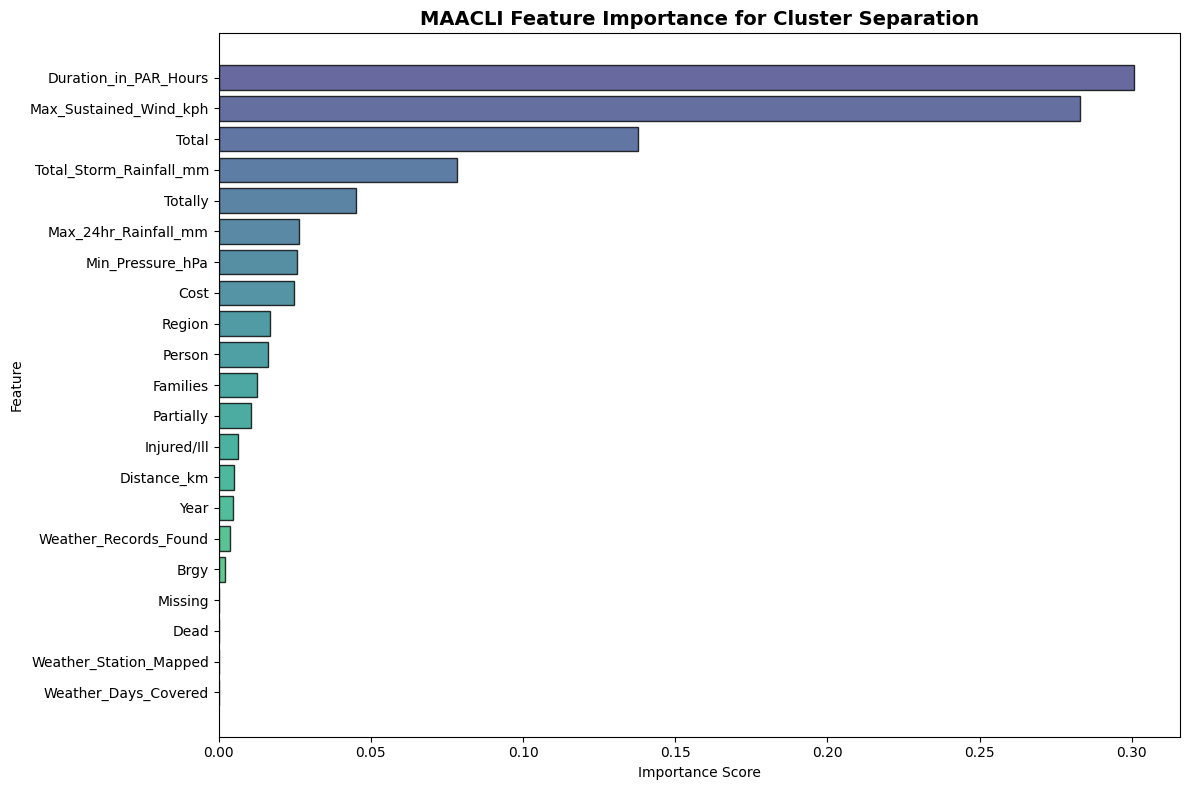


=== MAACLI Interpretation Summary ===
✓ Model-Agnostic: Works with KMeans clustering
✓ Algorithm-Agnostic: Uses surrogate classifier for interpretation
✓ Global Interpretability: Feature importance across all clusters
✓ Local Interpretability: Can predict individual cluster assignments


In [243]:
# Plot feature importance
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(importance_df)))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], 
                color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('MAACLI Feature Importance for Cluster Separation', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n=== MAACLI Interpretation Summary ===")
print("✓ Model-Agnostic: Works with KMeans clustering")
print("✓ Algorithm-Agnostic: Uses surrogate classifier for interpretation")
print("✓ Global Interpretability: Feature importance across all clusters")
print("✓ Local Interpretability: Can predict individual cluster assignments")

## 8. Cluster Profiling and Analysis

In [244]:
# Compute cluster statistics
print("=== Cluster Profiles (Mean Values) ===")

cluster_means = df_clustered.groupby('cluster_label')[numerical_columns].mean()
print(cluster_means.round(2))

=== Cluster Profiles (Mean Values) ===
                  Year  Region  Families    Person   Brgy  Dead  Injured/Ill  \
cluster_label                                                                  
0              2021.56    4.58   1023.86   3900.50   8.43  0.02         0.14   
1              2020.79    6.51  11624.67  44761.73  30.91  2.53         5.04   
2              2020.46    4.48    588.66   2388.91   6.63  0.01         0.12   

               Missing  Totally  Partially  ...        Cost  Distance_km  \
cluster_label                               ...                            
0                 0.00     8.93      67.85  ...   158983.22        37.73   
1                 0.07  1208.93    3543.89  ...  4648619.71        33.97   
2                 0.00     8.55      65.45  ...    55321.76        37.37   

               Duration_in_PAR_Hours  Max_Sustained_Wind_kph  \
cluster_label                                                  
0                             101.08               

In [245]:
# Compute quantile profiles for each cluster
print("=== Cluster Quantile Profiles ===")

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
quantile_data = []

for cluster in sorted(df_clustered['cluster_label'].unique()):
    cluster_data = df_clustered[df_clustered['cluster_label'] == cluster]
    
    for feature in numerical_columns:
        feature_values = cluster_data[feature]
        
        for q in quantiles:
            quantile_value = feature_values.quantile(q)
            quantile_data.append({
                'Cluster': cluster,
                'Feature': feature,
                'Quantile': f'Q{int(q*100):02d}',
                'Value': quantile_value
            })

quantile_profiles = pd.DataFrame(quantile_data)

# Display for each cluster
for cluster in sorted(df_clustered['cluster_label'].unique()):
    print(f"\n--- Cluster {cluster} (n={cluster_counts[cluster]:,}) ---")
    cluster_profile = quantile_profiles[quantile_profiles['Cluster'] == cluster]
    pivot_table = cluster_profile.pivot(index='Feature', columns='Quantile', values='Value')
    print(pivot_table.round(2))

=== Cluster Quantile Profiles ===

--- Cluster 0 (n=1,206) ---
Quantile                     Q05      Q25      Q50      Q75        Q95
Feature                                                               
Brgy                        0.00     1.00     5.00    12.00      28.00
Cost                        0.00     0.00     0.00     0.00  925761.40
Dead                        0.00     0.00     0.00     0.00       0.00
Distance_km                 6.81    20.56    35.13    53.40      72.44
Duration_in_PAR_Hours      60.00    78.00   114.00   124.70     124.70
Families                    0.00    18.00   163.00   928.75    4608.25
Injured/Ill                 0.00     0.00     0.00     0.00       0.00
Max_24hr_Rainfall_mm       39.00    72.80   106.00   140.00     255.80
Max_Sustained_Wind_kph     55.00   110.00   110.00   150.00     195.00
Min_Pressure_hPa          981.40   991.10   996.00   999.80    1004.30
Missing                     0.00     0.00     0.00     0.00       0.00
Partially     

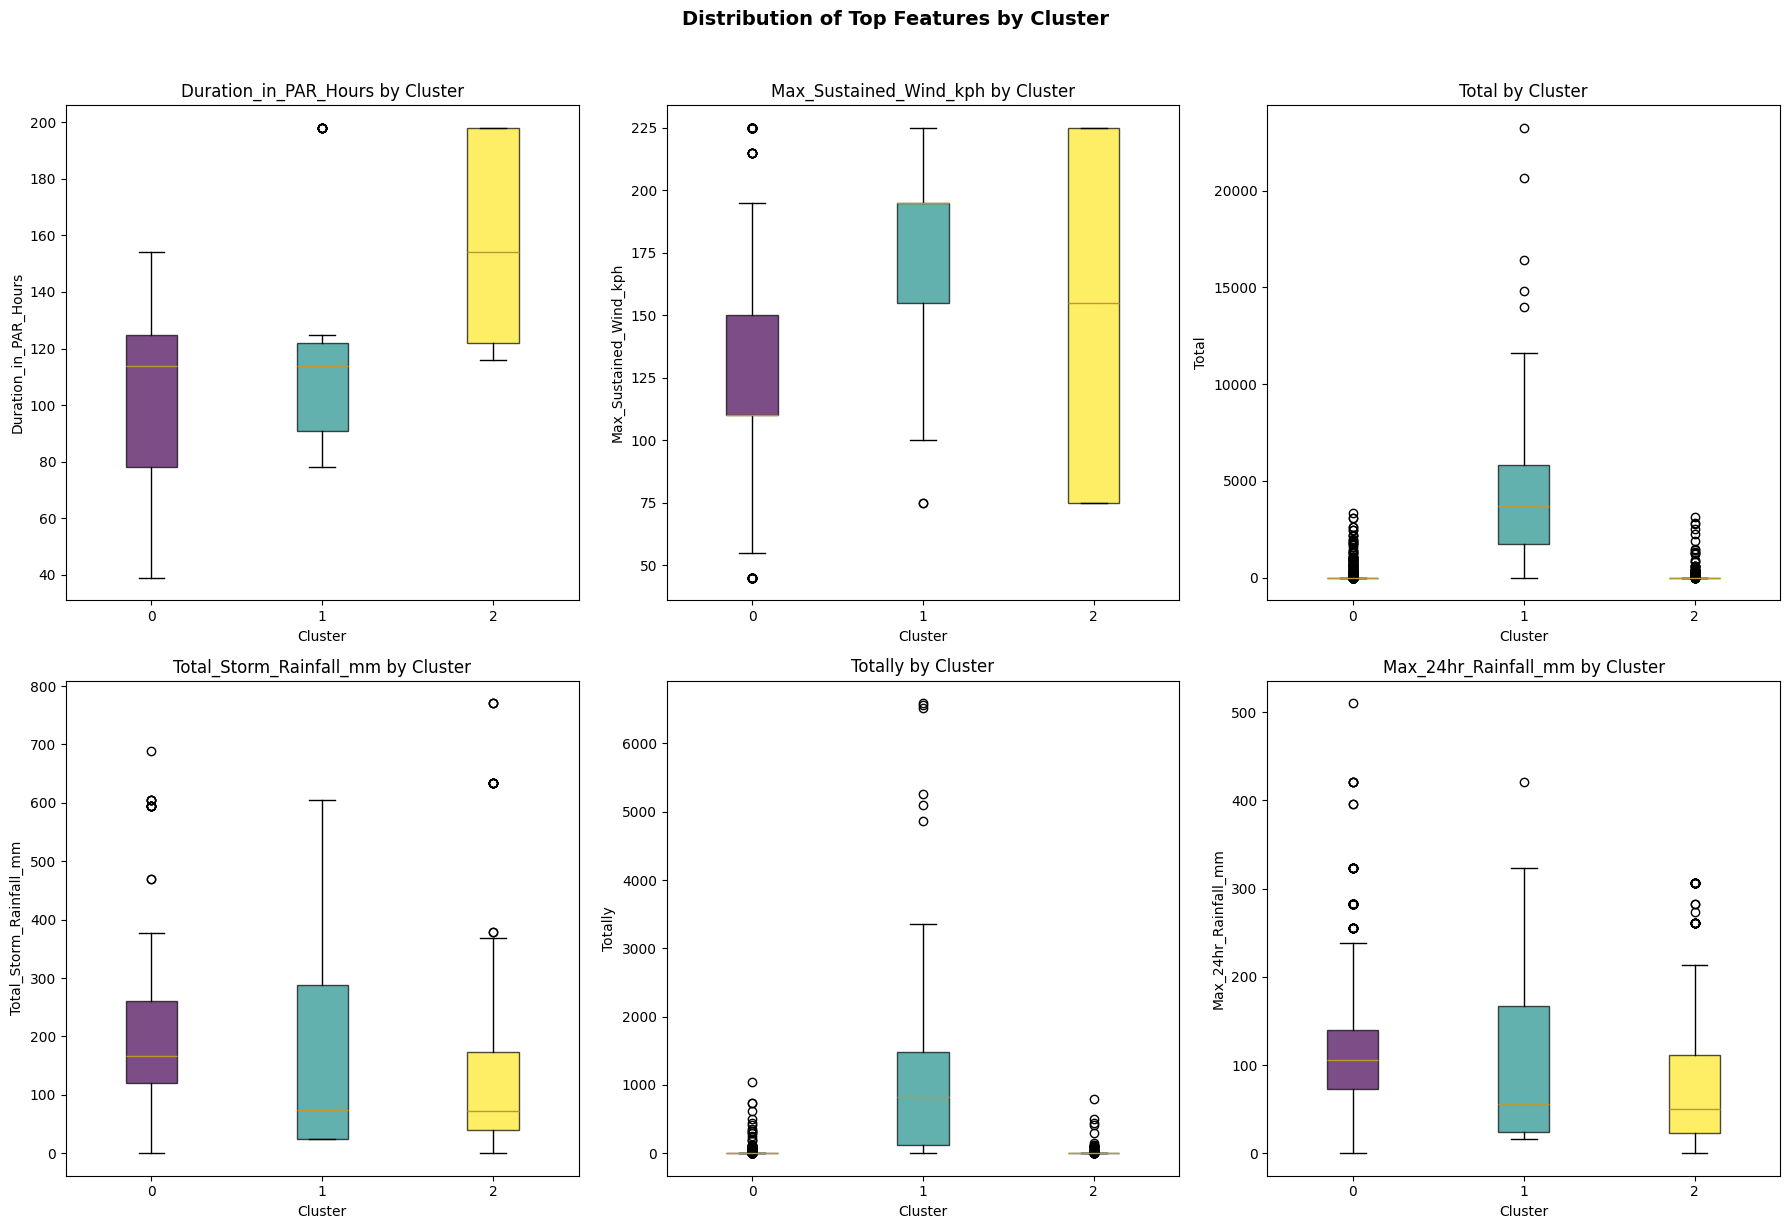

In [246]:
# Visualize cluster profiles for top features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Select top 6 important features for visualization
top_6_features = importance_df.head(6)['Feature'].tolist()

for i, feature in enumerate(top_6_features):
    ax = axes[i]
    
    # Create box plot for each cluster
    data_to_plot = [df_clustered[df_clustered['cluster_label'] == c][feature].values 
                    for c in sorted(df_clustered['cluster_label'].unique())]
    
    bp = ax.boxplot(data_to_plot, patch_artist=True)
    
    # Color boxes
    colors = plt.cm.viridis(np.linspace(0, 1, len(data_to_plot)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} by Cluster')
    ax.set_xticklabels([f'{c}' for c in sorted(df_clustered['cluster_label'].unique())])

plt.suptitle('Distribution of Top Features by Cluster', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

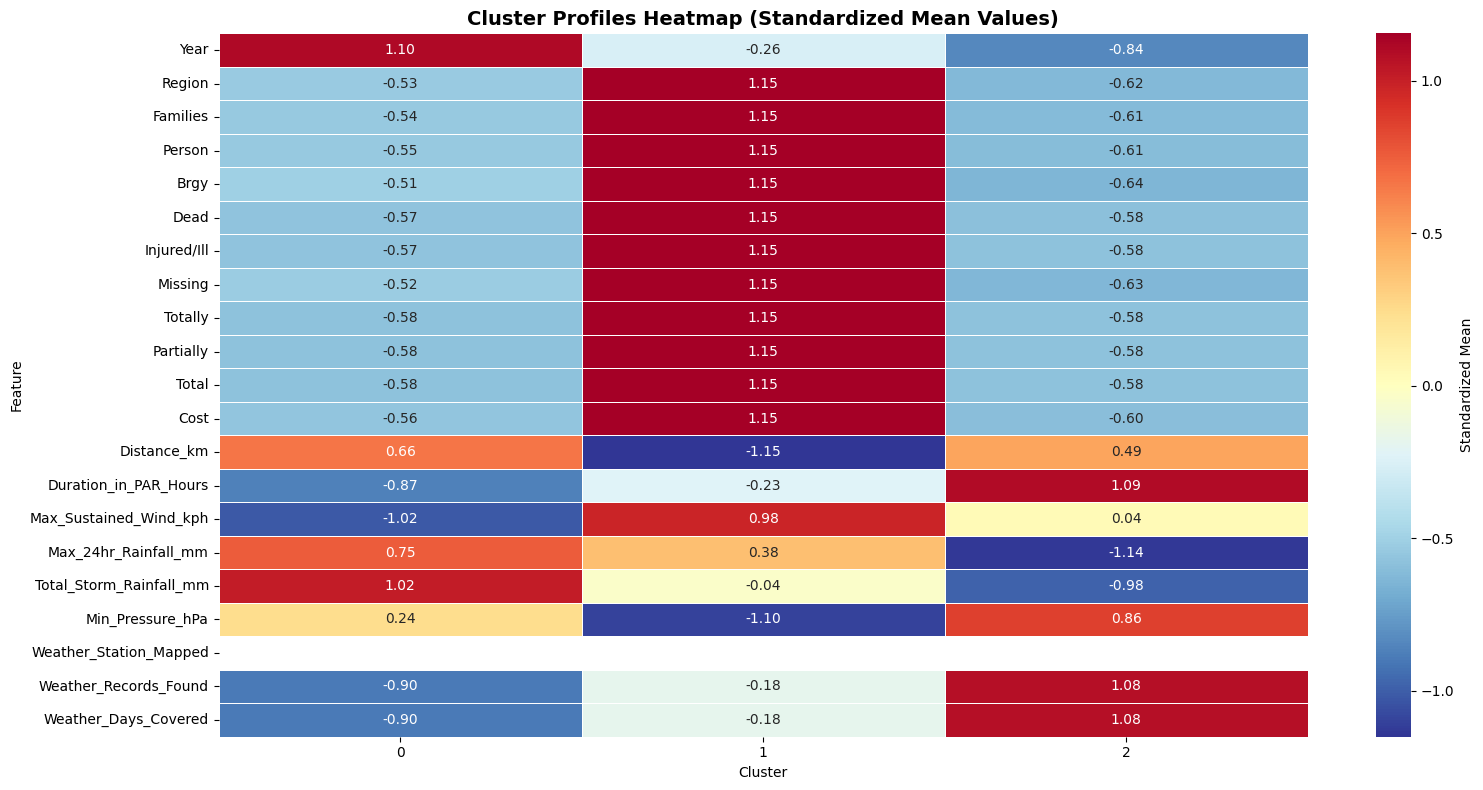

In [247]:
# Heatmap of cluster means (standardized)
plt.figure(figsize=(16, 8))

# Standardize cluster means for better visualization
cluster_means_standardized = (cluster_means - cluster_means.mean()) / cluster_means.std()

sns.heatmap(cluster_means_standardized.T, annot=True, cmap='RdYlBu_r', 
            center=0, fmt='.2f', linewidths=0.5,
            cbar_kws={'label': 'Standardized Mean'})
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.title('Cluster Profiles Heatmap (Standardized Mean Values)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Cluster Interpretation and Naming

In [248]:
# Generate cluster interpretations based on key features
print("=== Cluster Interpretation ===")

# Key impact features for interpretation
impact_features = ['Families', 'Person', 'Dead', 'Injured/Ill', 'Missing', 
                   'Totally', 'Partially', 'Cost']
weather_features = ['Max_Sustained_Wind_kph', 'Max_24hr_Rainfall_mm', 
                    'Total_Storm_Rainfall_mm', 'Duration_in_PAR_Hours']

# Filter to existing columns
impact_features = [f for f in impact_features if f in numerical_columns]
weather_features = [f for f in weather_features if f in numerical_columns]

for cluster in sorted(df_clustered['cluster_label'].unique()):
    cluster_data = df_clustered[df_clustered['cluster_label'] == cluster]
    n_samples = len(cluster_data)
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster} (n={n_samples:,}, {n_samples/len(df_clustered)*100:.1f}%)")
    print(f"{'='*60}")
    
    # Impact metrics
    if impact_features:
        print("\n📊 Impact Metrics (Mean):")
        for feat in impact_features:
            mean_val = cluster_data[feat].mean()
            median_val = cluster_data[feat].median()
            print(f"   • {feat}: Mean={mean_val:,.2f}, Median={median_val:,.2f}")
    
    # Weather metrics
    if weather_features:
        print("\n🌀 Weather Metrics (Mean):")
        for feat in weather_features:
            mean_val = cluster_data[feat].mean()
            print(f"   • {feat}: {mean_val:.2f}")
    
    # Sample typhoons in this cluster
    if 'Typhoon Name' in df.columns:
        sample_typhoons = df[df['cluster_label'] == cluster]['Typhoon Name'].unique()[:5]
        print(f"\n🌊 Sample Typhoons: {', '.join(sample_typhoons)}")

=== Cluster Interpretation ===

CLUSTER 0 (n=1,206, 67.9%)

📊 Impact Metrics (Mean):
   • Families: Mean=1,023.86, Median=163.00
   • Person: Mean=3,900.50, Median=612.50
   • Dead: Mean=0.02, Median=0.00
   • Injured/Ill: Mean=0.14, Median=0.00
   • Missing: Mean=0.00, Median=0.00
   • Totally: Mean=8.93, Median=0.00
   • Partially: Mean=67.85, Median=0.00
   • Cost: Mean=158,983.22, Median=0.00

🌀 Weather Metrics (Mean):
   • Max_Sustained_Wind_kph: 128.95
   • Max_24hr_Rainfall_mm: 115.04
   • Total_Storm_Rainfall_mm: 189.99
   • Duration_in_PAR_Hours: 101.08

🌊 Sample Typhoons: BETTY, HENRY, KIKO, MARING, FLORITA

CLUSTER 1 (n=70, 3.9%)

📊 Impact Metrics (Mean):
   • Families: Mean=11,624.67, Median=7,852.00
   • Person: Mean=44,761.73, Median=27,838.00
   • Dead: Mean=2.53, Median=0.00
   • Injured/Ill: Mean=5.04, Median=0.00
   • Missing: Mean=0.07, Median=0.00
   • Totally: Mean=1,208.93, Median=823.00
   • Partially: Mean=3,543.89, Median=2,652.00
   • Cost: Mean=4,648,619.71, 

## 10. Results Summary and Export

In [249]:
# Print comprehensive summary
print("="*70)
print("         COMPLETE CLUSTERING ANALYSIS SUMMARY")
print("="*70)

print(f"\n📁 Dataset Information:")
print(f"   • Original shape: {df.shape}")
print(f"   • Features used: {len(numerical_columns)} numerical features")

print(f"\n📉 PCA Results:")
print(f"   • Components: {X_pca.shape[1]}")
print(f"   • Total explained variance: {sum(pca.explained_variance_ratio_):.3f} ({sum(pca.explained_variance_ratio_)*100:.1f}%)")

print(f"\n🎯 Optimal Clustering Configuration:")
print(f"   • Algorithm: KMeans")
print(f"   • Number of clusters: {best_params['n_clusters']}")
print(f"   • Initialization: {best_params['init']}")
print(f"   • N_init: {best_params['n_init']}")
print(f"   • Silhouette Score: {best_score:.4f}")

print(f"\n📊 Cluster Distribution:")
for cluster, count in cluster_counts.items():
    print(f"   • Cluster {cluster}: {count:,} samples ({count/len(cluster_labels)*100:.1f}%)")

print(f"\n🔍 MAACLI Interpretability:")
print(f"   • Surrogate model: {model_type}")
print(f"   • Surrogate accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"   • Top 3 important features: {', '.join(top_features[:3])}")

         COMPLETE CLUSTERING ANALYSIS SUMMARY

📁 Dataset Information:
   • Original shape: (1776, 31)
   • Features used: 21 numerical features

📉 PCA Results:
   • Components: 10
   • Total explained variance: 0.868 (86.8%)

🎯 Optimal Clustering Configuration:
   • Algorithm: KMeans
   • Number of clusters: 3
   • Initialization: random
   • N_init: 40
   • Silhouette Score: 0.2096

📊 Cluster Distribution:
   • Cluster 0: 1,206 samples (67.9%)
   • Cluster 1: 70 samples (3.9%)
   • Cluster 2: 500 samples (28.2%)

🔍 MAACLI Interpretability:
   • Surrogate model: XGBoost
   • Surrogate accuracy: 0.981 (98.1%)
   • Top 3 important features: Duration_in_PAR_Hours, Max_Sustained_Wind_kph, Total


In [250]:
# Save results
print("\n=== Saving Results ===")

try:
    # Save clustered dataset
    output_path = '../data/clustered_typhoon_data.csv'
    df.to_csv(output_path, index=False)
    print(f"✓ Clustered dataset saved: {output_path}")
    
    # Save cluster profiles
    cluster_means.to_csv('../data/cluster_profiles.csv')
    print(f"✓ Cluster profiles saved: ../data/cluster_profiles.csv")
    
    # Save feature importance
    importance_df.to_csv('../data/feature_importance_maacli.csv', index=False)
    print(f"✓ Feature importance saved: ../data/feature_importance_maacli.csv")
    
    # Save quantile profiles
    quantile_summary = quantile_profiles.pivot_table(
        index=['Cluster', 'Feature'], 
        columns='Quantile', 
        values='Value'
    )
    quantile_summary.to_csv('../data/cluster_quantile_profiles.csv')
    print(f"✓ Quantile profiles saved: ../data/cluster_quantile_profiles.csv")
    
except Exception as e:
    print(f"⚠ Warning: Could not save some files - {e}")

print("\n" + "="*70)
print("                    ANALYSIS COMPLETE")
print("="*70)
print("\nThis clustering analysis successfully implemented:")
print("  ✓ Data preprocessing and feature scaling")
print("  ✓ Correlation analysis")
print("  ✓ PCA dimensionality reduction")
print("  ✓ Optuna hyperparameter optimization")
print("  ✓ KMeans clustering")
print("  ✓ MAACLI interpretability framework")
print("  ✓ Comprehensive cluster profiling")
print("  ✓ Results visualization and export")


=== Saving Results ===
✓ Clustered dataset saved: ../data/clustered_typhoon_data.csv
✓ Cluster profiles saved: ../data/cluster_profiles.csv
✓ Feature importance saved: ../data/feature_importance_maacli.csv
✓ Quantile profiles saved: ../data/cluster_quantile_profiles.csv

                    ANALYSIS COMPLETE

This clustering analysis successfully implemented:
  ✓ Data preprocessing and feature scaling
  ✓ Correlation analysis
  ✓ PCA dimensionality reduction
  ✓ Optuna hyperparameter optimization
  ✓ KMeans clustering
  ✓ MAACLI interpretability framework
  ✓ Comprehensive cluster profiling
  ✓ Results visualization and export


# Clustering Algorithm Benchmarking: KMeans vs K-Prototypes

This notebook benchmarks three clustering approaches for typhoon impact data:

1. **KMeans with One-Hot Encoding** - Converts categorical variables to binary columns
2. **KMeans with Label Encoding** - Converts categorical variables to integers
3. **K-Prototypes** - Native mixed-type clustering algorithm

## Evaluation Metrics:
- **Silhouette Score** - Measures cluster cohesion and separation (-1 to 1, higher is better)
- **Calinski-Harabasz Index** - Ratio of between-cluster to within-cluster variance (higher is better)
- **Davies-Bouldin Index** - Average similarity between clusters (lower is better)
- **Execution Time** - Computational efficiency

## 1. Import Libraries and Setup

In [251]:
# Core libraries
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.compose import ColumnTransformer

# K-Prototypes
try:
    from kmodes.kprototypes import KPrototypes
    KPROTOTYPES_AVAILABLE = True
except ImportError:
    KPROTOTYPES_AVAILABLE = False
    print("⚠ kmodes not installed. Install with: pip install kmodes")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Style settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully!")
print(f"✓ K-Prototypes available: {KPROTOTYPES_AVAILABLE}")

✓ Libraries imported successfully!
✓ K-Prototypes available: True


## 2. Load and Explore Data

In [252]:
# Load dataset
df = pd.read_csv('../data/typhoon_impact_with_extreme_weather.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumn Types:")
print(df.dtypes.value_counts())
df.head()

Dataset Shape: (1776, 30)

Column Types:
int64      16
object      8
float64     6
Name: count, dtype: int64


,Typhoon Name,Year,Region,Province,City/Municipality,Families,Person,Brgy,Dead,Injured/Ill,...,PAR_END,Duration_in_PAR_Hours,Max_Sustained_Wind_kph,Typhoon_Type,Max_24hr_Rainfall_mm,Total_Storm_Rainfall_mm,Min_Pressure_hPa,Weather_Station_Mapped,Weather_Records_Found,Weather_Days_Covered
0,BETTY,2023,2,BATANES,BASCO,3608,11120,6,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
1,BETTY,2023,2,BATANES,ITBAYAT,968,3028,5,0,0,...,6/1/2023,133.0,195,STY,20.3,32.71,1000.5,1,6,6
2,BETTY,2023,2,BATANES,IVANA,444,1532,4,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
3,BETTY,2023,2,BATANES,MAHATAO,575,1792,4,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
4,BETTY,2023,2,BATANES,SABTANG,575,1955,6,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6


In [253]:
# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove identifier/date columns that shouldn't be used for clustering
exclude_cols = ['PAR_START', 'PAR_END', 'Quantity']
categorical_columns = [c for c in categorical_columns if c not in exclude_cols]
numerical_columns = [c for c in numerical_columns if c not in exclude_cols]

print(f"=== Categorical Columns ({len(categorical_columns)}) ===")
for col in categorical_columns:
    print(f"  • {col}: {df[col].nunique()} unique values")

print(f"\n=== Numerical Columns ({len(numerical_columns)}) ===")
for col in numerical_columns:
    print(f"  • {col}")

=== Categorical Columns (6) ===
  • Typhoon Name: 25 unique values
  • Province: 24 unique values
  • City/Municipality: 442 unique values
  • Nearest_Station: 22 unique values
  • Station_Province: 16 unique values
  • Typhoon_Type: 5 unique values

=== Numerical Columns (21) ===
  • Year
  • Region
  • Families
  • Person
  • Brgy
  • Dead
  • Injured/Ill
  • Missing
  • Totally
  • Partially
  • Total
  • Cost
  • Distance_km
  • Duration_in_PAR_Hours
  • Max_Sustained_Wind_kph
  • Max_24hr_Rainfall_mm
  • Total_Storm_Rainfall_mm
  • Min_Pressure_hPa
  • Weather_Station_Mapped
  • Weather_Records_Found
  • Weather_Days_Covered


## 3. Data Preprocessing

In [254]:
# Create a clean copy for clustering
df_clean = df.copy()

# Drop columns we don't want for clustering
cols_to_drop = ['PAR_START', 'PAR_END', 'Quantity']
df_clean = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns], errors='ignore')

# Handle missing values
print("Missing values before handling:")
print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])

# Fill missing numerical with median, categorical with mode
for col in numerical_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

for col in categorical_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

print(f"\n✓ Data cleaned. Shape: {df_clean.shape}")

Missing values before handling:
Series([], dtype: int64)

✓ Data cleaned. Shape: (1776, 27)


In [255]:
# Select features for clustering
# Use key categorical features for mixed-type clustering
cat_features = ['Typhoon Name', 'Province', 'Typhoon_Type', 'Nearest_Station']
cat_features = [c for c in cat_features if c in df_clean.columns]

# Numerical features (impact and weather metrics)
num_features = ['Families', 'Person', 'Dead', 'Injured/Ill', 'Missing', 
                'Totally', 'Partially', 'Cost', 'Duration_in_PAR_Hours',
                'Max_Sustained_Wind_kph', 'Max_24hr_Rainfall_mm', 
                'Total_Storm_Rainfall_mm', 'Min_Pressure_hPa', 'Distance_km']
num_features = [c for c in num_features if c in df_clean.columns]

print(f"Categorical features for clustering: {cat_features}")
print(f"Numerical features for clustering: {num_features}")

# Extract feature matrices
X_cat = df_clean[cat_features].copy()
X_num = df_clean[num_features].copy()

print(f"\nCategorical shape: {X_cat.shape}")
print(f"Numerical shape: {X_num.shape}")

Categorical features for clustering: ['Typhoon Name', 'Province', 'Typhoon_Type', 'Nearest_Station']
Numerical features for clustering: ['Families', 'Person', 'Dead', 'Injured/Ill', 'Missing', 'Totally', 'Partially', 'Cost', 'Duration_in_PAR_Hours', 'Max_Sustained_Wind_kph', 'Max_24hr_Rainfall_mm', 'Total_Storm_Rainfall_mm', 'Min_Pressure_hPa', 'Distance_km']

Categorical shape: (1776, 4)
Numerical shape: (1776, 14)


## 4. Prepare Data for Each Clustering Method

In [256]:
# Standardize numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
X_num_scaled_df = pd.DataFrame(X_num_scaled, columns=num_features)

print("✓ Numerical features standardized")

✓ Numerical features standardized


In [257]:
# Method 1: One-Hot Encoding for KMeans
print("=== Preparing One-Hot Encoded Data ===")

# One-hot encode categorical features
X_cat_onehot = pd.get_dummies(X_cat, drop_first=False)
print(f"One-hot encoded shape: {X_cat_onehot.shape}")

# Combine with scaled numerical
X_onehot = np.hstack([X_num_scaled, X_cat_onehot.values])
print(f"Final one-hot encoded data shape: {X_onehot.shape}")

=== Preparing One-Hot Encoded Data ===
One-hot encoded shape: (1776, 76)
Final one-hot encoded data shape: (1776, 90)


In [258]:
# Method 2: Label Encoding for KMeans
print("=== Preparing Label Encoded Data ===")

label_encoders = {}
X_cat_label = X_cat.copy()

for col in cat_features:
    le = LabelEncoder()
    X_cat_label[col] = le.fit_transform(X_cat[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} classes")

# Scale label encoded categorical (treat as ordinal)
scaler_label = StandardScaler()
X_cat_label_scaled = scaler_label.fit_transform(X_cat_label)

# Combine with scaled numerical
X_label = np.hstack([X_num_scaled, X_cat_label_scaled])
print(f"\nFinal label encoded data shape: {X_label.shape}")

=== Preparing Label Encoded Data ===
  Typhoon Name: 25 classes
  Province: 24 classes
  Typhoon_Type: 5 classes
  Nearest_Station: 22 classes

Final label encoded data shape: (1776, 18)


In [259]:
# Method 3: K-Prototypes (mixed data)
print("=== Preparing K-Prototypes Data ===")

# K-Prototypes expects numerical columns first, then categorical
X_kproto = np.hstack([X_num_scaled, X_cat.values])

# Get indices of categorical columns (they come after numerical)
cat_indices = list(range(len(num_features), len(num_features) + len(cat_features)))

print(f"K-Prototypes data shape: {X_kproto.shape}")
print(f"Categorical column indices: {cat_indices}")

=== Preparing K-Prototypes Data ===
K-Prototypes data shape: (1776, 18)
Categorical column indices: [14, 15, 16, 17]


## 5. Benchmarking Functions

In [260]:
def benchmark_kmeans(X, k_range, method_name):
    """
    Benchmark KMeans clustering across different k values.
    
    Returns:
        results_df: DataFrame with metrics for each k
    """
    results = []
    
    for k in k_range:
        start_time = time.time()
        
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, 
                        max_iter=300, random_state=42)
        labels = kmeans.fit_predict(X)
        
        exec_time = time.time() - start_time
        
        # Calculate metrics
        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)
        inertia = kmeans.inertia_
        
        results.append({
            'Method': method_name,
            'k': k,
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski,
            'Davies-Bouldin': davies,
            'Inertia': inertia,
            'Time (s)': exec_time
        })
        
        print(f"  k={k}: Silhouette={silhouette:.4f}, Time={exec_time:.2f}s")
    
    return pd.DataFrame(results)


def benchmark_kprototypes(X, cat_indices, k_range):
    """
    Benchmark K-Prototypes clustering across different k values.
    
    Returns:
        results_df: DataFrame with metrics for each k
    """
    if not KPROTOTYPES_AVAILABLE:
        print("K-Prototypes not available!")
        return pd.DataFrame()
    
    results = []
    
    for k in k_range:
        start_time = time.time()
        
        kproto = KPrototypes(n_clusters=k, init='Cao', n_init=5, 
                             max_iter=100, random_state=42, verbose=0)
        labels = kproto.fit_predict(X, categorical=cat_indices)
        
        exec_time = time.time() - start_time
        
        # For silhouette, we need numerical data only
        X_num_only = X[:, :len(num_features)].astype(float)
        
        # Calculate metrics on numerical portion
        silhouette = silhouette_score(X_num_only, labels)
        calinski = calinski_harabasz_score(X_num_only, labels)
        davies = davies_bouldin_score(X_num_only, labels)
        cost = kproto.cost_
        
        results.append({
            'Method': 'K-Prototypes',
            'k': k,
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski,
            'Davies-Bouldin': davies,
            'Inertia': cost,
            'Time (s)': exec_time
        })
        
        print(f"  k={k}: Silhouette={silhouette:.4f}, Time={exec_time:.2f}s")
    
    return pd.DataFrame(results)

## 6. Run Benchmarks

In [261]:
# Define k range for testing
k_range = range(2, 11)

print("="*60)
print("CLUSTERING ALGORITHM BENCHMARKING")
print("="*60)

CLUSTERING ALGORITHM BENCHMARKING


In [262]:
# Benchmark 1: KMeans with One-Hot Encoding
print("\n" + "="*60)
print("Method 1: KMeans with One-Hot Encoding")
print("="*60)
results_onehot = benchmark_kmeans(X_onehot, k_range, 'KMeans (One-Hot)')


Method 1: KMeans with One-Hot Encoding


  k=2: Silhouette=0.6008, Time=0.07s
  k=3: Silhouette=0.1239, Time=0.16s
  k=3: Silhouette=0.1239, Time=0.16s
  k=4: Silhouette=0.1344, Time=0.12s
  k=5: Silhouette=0.1126, Time=0.08s
  k=4: Silhouette=0.1344, Time=0.12s
  k=5: Silhouette=0.1126, Time=0.08s
  k=6: Silhouette=0.1613, Time=0.09s
  k=6: Silhouette=0.1613, Time=0.09s
  k=7: Silhouette=0.1199, Time=0.13s
  k=7: Silhouette=0.1199, Time=0.13s
  k=8: Silhouette=0.1682, Time=0.15s
  k=8: Silhouette=0.1682, Time=0.15s
  k=9: Silhouette=0.1698, Time=0.12s
  k=9: Silhouette=0.1698, Time=0.12s
  k=10: Silhouette=0.1648, Time=0.19s
  k=10: Silhouette=0.1648, Time=0.19s


In [263]:
# Benchmark 2: KMeans with Label Encoding
print("\n" + "="*60)
print("Method 2: KMeans with Label Encoding")
print("="*60)
results_label = benchmark_kmeans(X_label, k_range, 'KMeans (Label Enc)')


Method 2: KMeans with Label Encoding
  k=2: Silhouette=0.5935, Time=0.24s
  k=3: Silhouette=0.1686, Time=0.05s
  k=2: Silhouette=0.5935, Time=0.24s
  k=3: Silhouette=0.1686, Time=0.05s
  k=4: Silhouette=0.1523, Time=0.07s
  k=5: Silhouette=0.1552, Time=0.07s
  k=4: Silhouette=0.1523, Time=0.07s
  k=5: Silhouette=0.1552, Time=0.07s
  k=6: Silhouette=0.1561, Time=0.06s
  k=6: Silhouette=0.1561, Time=0.06s
  k=7: Silhouette=0.1771, Time=0.08s
  k=7: Silhouette=0.1771, Time=0.08s
  k=8: Silhouette=0.1799, Time=0.06s
  k=8: Silhouette=0.1799, Time=0.06s
  k=9: Silhouette=0.1820, Time=0.06s
  k=9: Silhouette=0.1820, Time=0.06s
  k=10: Silhouette=0.1866, Time=0.09s
  k=10: Silhouette=0.1866, Time=0.09s


In [264]:
# Benchmark 3: K-Prototypes
print("\n" + "="*60)
print("Method 3: K-Prototypes")
print("="*60)

if KPROTOTYPES_AVAILABLE:
    results_kproto = benchmark_kprototypes(X_kproto, cat_indices, k_range)
else:
    print("Skipping - kmodes package not installed")
    results_kproto = pd.DataFrame()


Method 3: K-Prototypes


  k=2: Silhouette=0.6665, Time=5.86s
  k=3: Silhouette=0.1785, Time=5.20s
  k=3: Silhouette=0.1785, Time=5.20s
  k=4: Silhouette=0.1814, Time=7.11s
  k=4: Silhouette=0.1814, Time=7.11s
  k=5: Silhouette=0.1734, Time=6.39s
  k=5: Silhouette=0.1734, Time=6.39s
  k=6: Silhouette=0.2073, Time=6.13s
  k=6: Silhouette=0.2073, Time=6.13s
  k=7: Silhouette=0.1793, Time=5.22s
  k=7: Silhouette=0.1793, Time=5.22s
  k=8: Silhouette=0.2200, Time=5.02s
  k=8: Silhouette=0.2200, Time=5.02s
  k=9: Silhouette=0.1952, Time=5.58s
  k=9: Silhouette=0.1952, Time=5.58s
  k=10: Silhouette=0.1981, Time=6.89s
  k=10: Silhouette=0.1981, Time=6.89s


## 7. Combine and Analyze Results

In [265]:
# Combine all results
all_results = pd.concat([results_onehot, results_label, results_kproto], ignore_index=True)

print("=== Complete Benchmark Results ===")
print(all_results.to_string(index=False))

=== Complete Benchmark Results ===
            Method  k  Silhouette  Calinski-Harabasz  Davies-Bouldin      Inertia  Time (s)
  KMeans (One-Hot)  2    0.600801         265.592620        1.689107 27068.664117  0.073251
  KMeans (One-Hot)  3    0.123930         228.746236        2.159172 24738.001607  0.156886
  KMeans (One-Hot)  4    0.134376         202.786279        1.986053 23167.433518  0.115253
  KMeans (One-Hot)  5    0.112573         193.307343        1.822062 21663.016887  0.079441
  KMeans (One-Hot)  6    0.161293         191.633893        1.621772 20191.034079  0.092719
  KMeans (One-Hot)  7    0.119941         187.180893        1.553002 19035.897842  0.130981
  KMeans (One-Hot)  8    0.168247         194.059050        1.534453 17599.182862  0.151248
  KMeans (One-Hot)  9    0.169809         201.307172        1.305470 16281.833615  0.115687
  KMeans (One-Hot) 10    0.164845         178.343410        1.577735 16303.351884  0.188418
KMeans (Label Enc)  2    0.593494         254

In [266]:
# Find best k for each method based on Silhouette Score
print("\n=== Best Configuration per Method (by Silhouette Score) ===")

best_results = all_results.loc[all_results.groupby('Method')['Silhouette'].idxmax()]
print(best_results[['Method', 'k', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'Time (s)']].to_string(index=False))


=== Best Configuration per Method (by Silhouette Score) ===
            Method  k  Silhouette  Calinski-Harabasz  Davies-Bouldin  Time (s)
      K-Prototypes  2    0.666497         340.408489        1.576631  5.861668
KMeans (Label Enc)  2    0.593494         254.693433        1.714675  0.239053
  KMeans (One-Hot)  2    0.600801         265.592620        1.689107  0.073251


In [267]:
# Summary statistics
print("\n=== Summary Statistics ===")

summary = all_results.groupby('Method').agg({
    'Silhouette': ['mean', 'max', 'std'],
    'Calinski-Harabasz': ['mean', 'max'],
    'Davies-Bouldin': ['mean', 'min'],
    'Time (s)': ['mean', 'sum']
}).round(4)

print(summary)


=== Summary Statistics ===
                   Silhouette                 Calinski-Harabasz            \
                         mean     max     std              mean       max   
Method                                                                      
K-Prototypes           0.2444  0.6665  0.1590          249.9263  340.4085   
KMeans (Label Enc)     0.2168  0.5935  0.1418          211.1173  254.6934   
KMeans (One-Hot)       0.1951  0.6008  0.1538          204.7730  265.5926   

                   Davies-Bouldin         Time (s)           
                             mean     min     mean      sum  
Method                                                       
K-Prototypes               1.6150  1.3804   5.9339  53.4048  
KMeans (Label Enc)         1.6297  1.3315   0.0880   0.7921  
KMeans (One-Hot)           1.6943  1.3055   0.1227   1.1039  


## 8. Visualization of Results

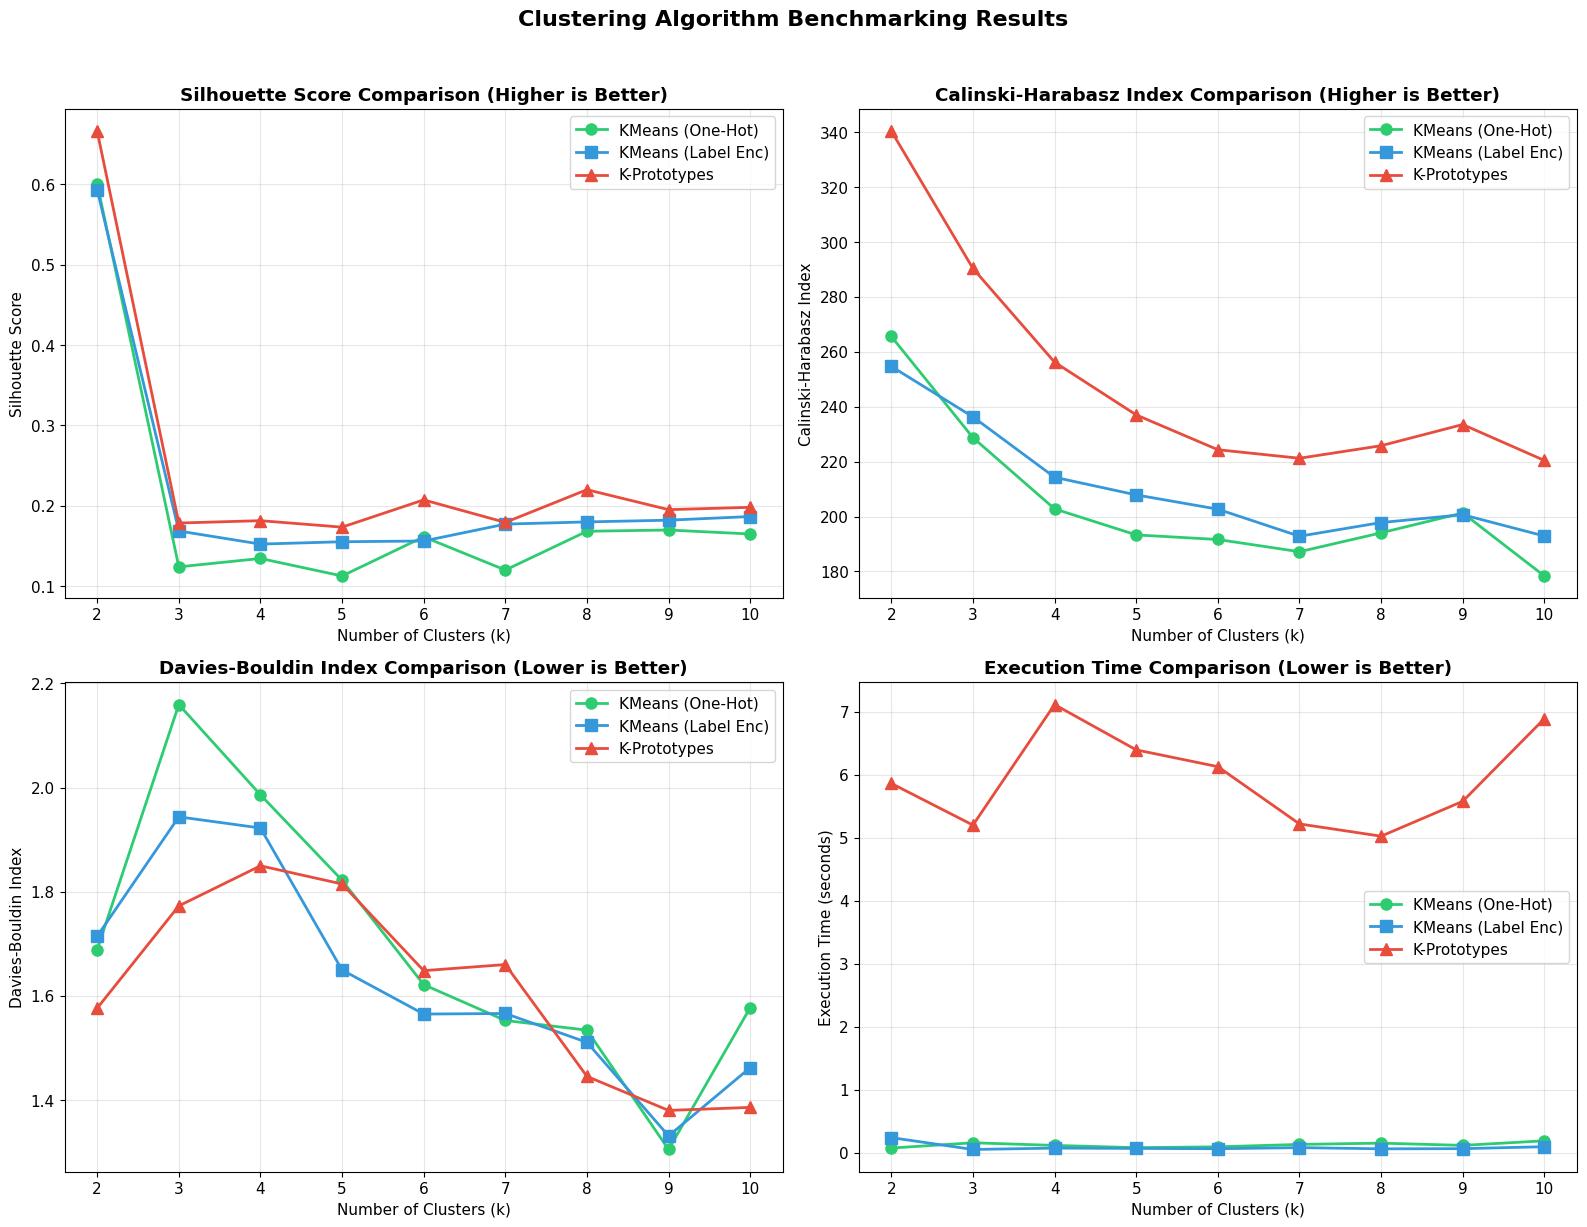

In [268]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

methods = all_results['Method'].unique()
colors = {'KMeans (One-Hot)': '#2ecc71', 'KMeans (Label Enc)': '#3498db', 'K-Prototypes': '#e74c3c'}
markers = {'KMeans (One-Hot)': 'o', 'KMeans (Label Enc)': 's', 'K-Prototypes': '^'}

# Plot 1: Silhouette Score
ax1 = axes[0, 0]
for method in methods:
    data = all_results[all_results['Method'] == method]
    ax1.plot(data['k'], data['Silhouette'], marker=markers.get(method, 'o'), 
             label=method, linewidth=2, markersize=8, color=colors.get(method))
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score Comparison (Higher is Better)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Calinski-Harabasz Index
ax2 = axes[0, 1]
for method in methods:
    data = all_results[all_results['Method'] == method]
    ax2.plot(data['k'], data['Calinski-Harabasz'], marker=markers.get(method, 'o'),
             label=method, linewidth=2, markersize=8, color=colors.get(method))
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Calinski-Harabasz Index')
ax2.set_title('Calinski-Harabasz Index Comparison (Higher is Better)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Davies-Bouldin Index
ax3 = axes[1, 0]
for method in methods:
    data = all_results[all_results['Method'] == method]
    ax3.plot(data['k'], data['Davies-Bouldin'], marker=markers.get(method, 'o'),
             label=method, linewidth=2, markersize=8, color=colors.get(method))
ax3.set_xlabel('Number of Clusters (k)')
ax3.set_ylabel('Davies-Bouldin Index')
ax3.set_title('Davies-Bouldin Index Comparison (Lower is Better)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Execution Time
ax4 = axes[1, 1]
for method in methods:
    data = all_results[all_results['Method'] == method]
    ax4.plot(data['k'], data['Time (s)'], marker=markers.get(method, 'o'),
             label=method, linewidth=2, markersize=8, color=colors.get(method))
ax4.set_xlabel('Number of Clusters (k)')
ax4.set_ylabel('Execution Time (seconds)')
ax4.set_title('Execution Time Comparison (Lower is Better)', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Clustering Algorithm Benchmarking Results', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

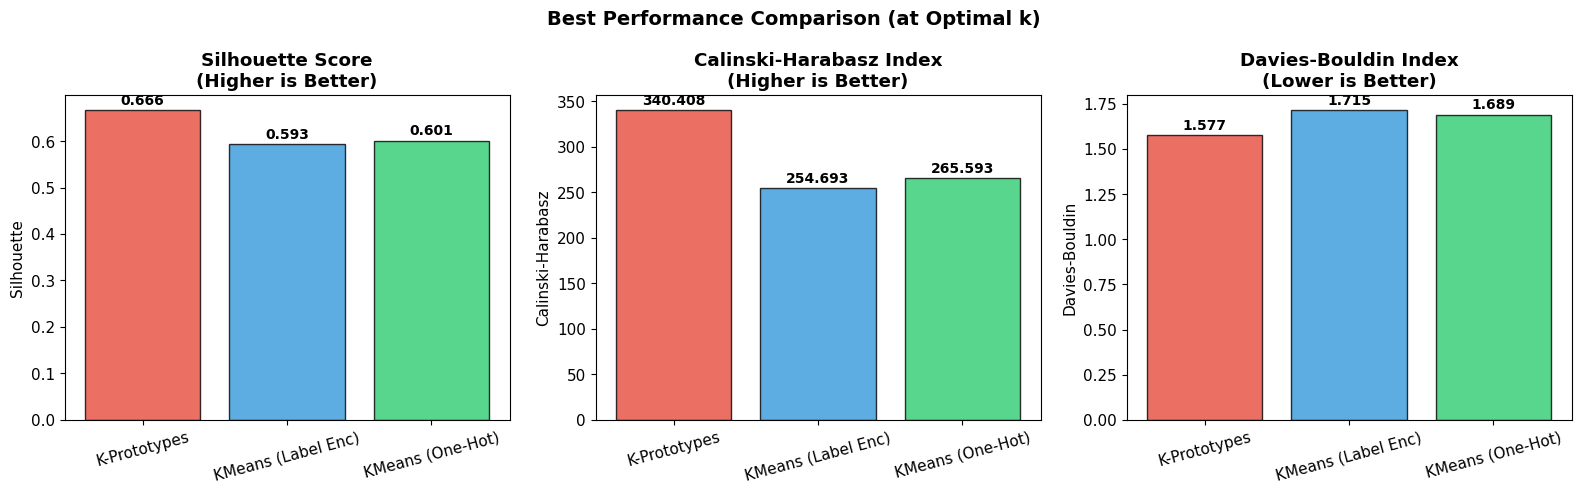

In [269]:
# Bar chart comparison at optimal k for each method
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']
titles = ['Silhouette Score\n(Higher is Better)', 
          'Calinski-Harabasz Index\n(Higher is Better)',
          'Davies-Bouldin Index\n(Lower is Better)']

for ax, metric, title in zip(axes, metrics, titles):
    best_per_method = all_results.loc[all_results.groupby('Method')['Silhouette'].idxmax()]
    
    bars = ax.bar(best_per_method['Method'], best_per_method[metric], 
                  color=[colors.get(m, '#95a5a6') for m in best_per_method['Method']],
                  edgecolor='black', alpha=0.8)
    
    # Add value labels
    for bar, val in zip(bars, best_per_method[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*bar.get_height(),
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel(metric)
    ax.set_title(title, fontweight='bold')
    ax.tick_params(axis='x', rotation=15)

plt.suptitle('Best Performance Comparison (at Optimal k)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Detailed Analysis with Best Configuration

In [270]:
# Get the overall best method and k
best_overall = all_results.loc[all_results['Silhouette'].idxmax()]
best_method = best_overall['Method']
best_k = int(best_overall['k'])

print("="*60)
print("BEST OVERALL CONFIGURATION")
print("="*60)
print(f"\nMethod: {best_method}")
print(f"Optimal k: {best_k}")
print(f"Silhouette Score: {best_overall['Silhouette']:.4f}")
print(f"Calinski-Harabasz: {best_overall['Calinski-Harabasz']:.2f}")
print(f"Davies-Bouldin: {best_overall['Davies-Bouldin']:.4f}")
print(f"Execution Time: {best_overall['Time (s)']:.2f}s")

BEST OVERALL CONFIGURATION

Method: K-Prototypes
Optimal k: 2
Silhouette Score: 0.6665
Calinski-Harabasz: 340.41
Davies-Bouldin: 1.5766
Execution Time: 5.86s


In [271]:
# Train the best model and analyze clusters
print(f"\n=== Training Best Model: {best_method} with k={best_k} ===")

if best_method == 'KMeans (One-Hot)':
    best_model = KMeans(n_clusters=best_k, init='k-means++', n_init=10, random_state=42)
    best_labels = best_model.fit_predict(X_onehot)
    X_for_viz = X_onehot
elif best_method == 'KMeans (Label Enc)':
    best_model = KMeans(n_clusters=best_k, init='k-means++', n_init=10, random_state=42)
    best_labels = best_model.fit_predict(X_label)
    X_for_viz = X_label
else:  # K-Prototypes
    best_model = KPrototypes(n_clusters=best_k, init='Cao', n_init=5, random_state=42)
    best_labels = best_model.fit_predict(X_kproto, categorical=cat_indices)
    X_for_viz = X_kproto[:, :len(num_features)].astype(float)

# Add labels to dataframe
df_clean['Cluster'] = best_labels

# Cluster distribution
print("\n=== Cluster Distribution ===")
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(best_labels) * 100
    print(f"  Cluster {cluster}: {count:,} samples ({pct:.1f}%)")


=== Training Best Model: K-Prototypes with k=2 ===

=== Cluster Distribution ===
  Cluster 0: 83 samples (4.7%)
  Cluster 1: 1,693 samples (95.3%)

=== Cluster Distribution ===
  Cluster 0: 83 samples (4.7%)
  Cluster 1: 1,693 samples (95.3%)


In [272]:
# Cluster profiles
print("\n=== Cluster Profiles (Mean Values) ===")

cluster_profiles = df_clean.groupby('Cluster')[num_features].mean()
print(cluster_profiles.round(2))


=== Cluster Profiles (Mean Values) ===
         Families    Person  Dead  Injured/Ill  Missing  Totally  Partially  \
Cluster                                                                       
0        11571.99  44818.90  2.13         4.99     0.06  1021.66    2971.90   
1          816.52   3137.51  0.02         0.10     0.00     8.78      68.49   

               Cost  Duration_in_PAR_Hours  Max_Sustained_Wind_kph  \
Cluster                                                              
0        4395738.18                 117.07                  178.49   
1         106291.64                 117.35                  137.38   

         Max_24hr_Rainfall_mm  Total_Storm_Rainfall_mm  Min_Pressure_hPa  \
Cluster                                                                    
0                      108.92                   155.23            981.02   
1                      103.61                   169.51            996.54   

         Distance_km  
Cluster               
0          

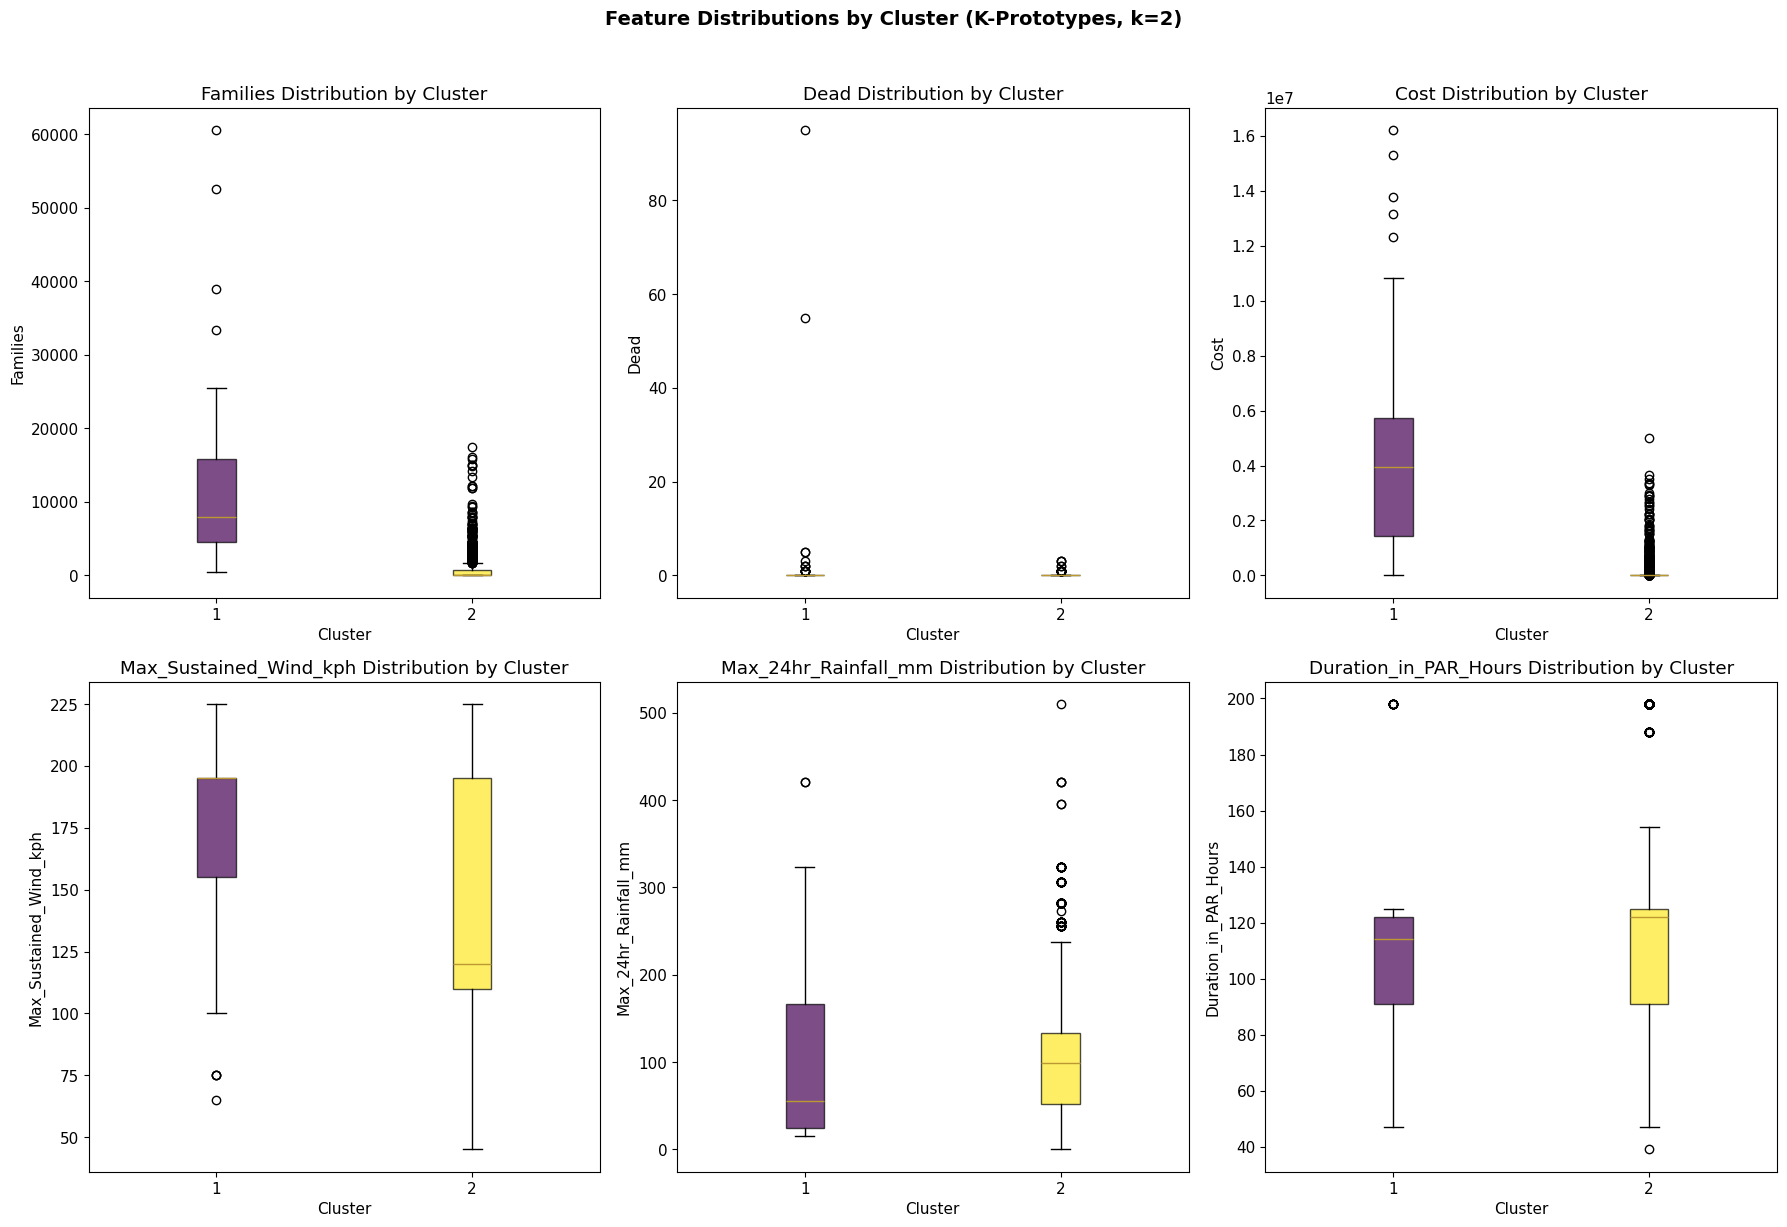

In [273]:
# Visualize cluster profiles
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Select key features to visualize
key_features = ['Families', 'Dead', 'Cost', 'Max_Sustained_Wind_kph', 
                'Max_24hr_Rainfall_mm', 'Duration_in_PAR_Hours']
key_features = [f for f in key_features if f in num_features][:6]

for i, feature in enumerate(key_features):
    ax = axes[i]
    
    # Box plot by cluster
    data_by_cluster = [df_clean[df_clean['Cluster'] == c][feature].values 
                       for c in range(best_k)]
    
    bp = ax.boxplot(data_by_cluster, patch_artist=True)
    
    # Color boxes
    cluster_colors = plt.cm.viridis(np.linspace(0, 1, best_k))
    for patch, color in zip(bp['boxes'], cluster_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} Distribution by Cluster')

plt.suptitle(f'Feature Distributions by Cluster ({best_method}, k={best_k})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 10. Final Summary and Recommendations

In [274]:
print("="*70)
print("                    BENCHMARKING SUMMARY")
print("="*70)

print("\n📊 METHODS COMPARED:")
print("  1. KMeans with One-Hot Encoding")
print(f"     - Features: {X_onehot.shape[1]} dimensions")
print("     - Pros: Preserves categorical information without ordinality assumption")
print("     - Cons: High dimensionality, sparse features")

print("\n  2. KMeans with Label Encoding")
print(f"     - Features: {X_label.shape[1]} dimensions")
print("     - Pros: Compact representation, faster computation")
print("     - Cons: Introduces artificial ordinality")

if KPROTOTYPES_AVAILABLE:
    print("\n  3. K-Prototypes")
    print(f"     - Features: {len(num_features)} numerical + {len(cat_features)} categorical")
    print("     - Pros: Native mixed-type handling, no encoding artifacts")
    print("     - Cons: Slower computation, fewer optimization options")

print("\n" + "="*70)
print("BEST RESULTS BY METHOD:")
print("="*70)

for method in methods:
    method_best = all_results[all_results['Method'] == method].loc[
        all_results[all_results['Method'] == method]['Silhouette'].idxmax()
    ]
    print(f"\n  {method}:")
    print(f"    • Best k: {int(method_best['k'])}")
    print(f"    • Silhouette: {method_best['Silhouette']:.4f}")
    print(f"    • Calinski-Harabasz: {method_best['Calinski-Harabasz']:.2f}")
    print(f"    • Davies-Bouldin: {method_best['Davies-Bouldin']:.4f}")
    print(f"    • Time: {method_best['Time (s)']:.2f}s")

print("\n" + "="*70)
print("🏆 RECOMMENDATION:")
print("="*70)
print(f"\n  Best Method: {best_method}")
print(f"  Optimal Clusters: {best_k}")
print(f"  Silhouette Score: {best_overall['Silhouette']:.4f}")

if best_overall['Silhouette'] > 0.5:
    quality = "STRONG"
elif best_overall['Silhouette'] > 0.25:
    quality = "REASONABLE"
else:
    quality = "WEAK"
print(f"  Cluster Quality: {quality}")

print("\n" + "="*70)

                    BENCHMARKING SUMMARY

📊 METHODS COMPARED:
  1. KMeans with One-Hot Encoding
     - Features: 90 dimensions
     - Pros: Preserves categorical information without ordinality assumption
     - Cons: High dimensionality, sparse features

  2. KMeans with Label Encoding
     - Features: 18 dimensions
     - Pros: Compact representation, faster computation
     - Cons: Introduces artificial ordinality

  3. K-Prototypes
     - Features: 14 numerical + 4 categorical
     - Pros: Native mixed-type handling, no encoding artifacts
     - Cons: Slower computation, fewer optimization options

BEST RESULTS BY METHOD:

  KMeans (One-Hot):
    • Best k: 2
    • Silhouette: 0.6008
    • Calinski-Harabasz: 265.59
    • Davies-Bouldin: 1.6891
    • Time: 0.07s

  KMeans (Label Enc):
    • Best k: 2
    • Silhouette: 0.5935
    • Calinski-Harabasz: 254.69
    • Davies-Bouldin: 1.7147
    • Time: 0.24s

  K-Prototypes:
    • Best k: 2
    • Silhouette: 0.6665
    • Calinski-Harabasz: 

In [275]:
# Save results
print("\n=== Saving Results ===")

try:
    # Save benchmark results
    all_results.to_csv('../data/clustering_benchmark_results.csv', index=False)
    print("✓ Benchmark results saved: ../data/clustering_benchmark_results.csv")
    
    # Save clustered data
    df_clean.to_csv('../data/clustered_typhoon_data.csv', index=False)
    print("✓ Clustered data saved: ../data/clustered_typhoon_data.csv")
    
    # Save cluster profiles
    cluster_profiles.to_csv('../data/cluster_profiles.csv')
    print("✓ Cluster profiles saved: ../data/cluster_profiles.csv")
    
except Exception as e:
    print(f"⚠ Error saving files: {e}")

print("\n✓ Benchmarking complete!")


=== Saving Results ===
✓ Benchmark results saved: ../data/clustering_benchmark_results.csv
✓ Clustered data saved: ../data/clustered_typhoon_data.csv
✓ Cluster profiles saved: ../data/cluster_profiles.csv

✓ Benchmarking complete!
